![Banner](https://webassets.inman.com/wp-content/uploads/2014/03/zillow-logo-use-this-one.png)

## Finding the zestimate errors

By: Jared Vahle

## Agenda
- Executive summary
- Wrangle
- Exploration
- Modeling
- Conclusion
- Next steps

## Executive Summary

### Goals
- Work through datascience pipline for zillow data, documenting the process.
- Use clustering and regression modeling to find clusters of houses that will imporove our model.
- Find drivers for log error in the zestimate

### Statistical testing:
I found that Location bedrooms and bathrooms all have a relationship with log error.

I also found that the log error was different when comparing large units to small units, and when comparing large lots to small lots.
### Clustering:
- The cluster of longitude and latited was not effective in predicting logerror
- The cluster of longitude latitude and square footage was not effective in predicting logerror
- The cluster of bedroom bathroom and tax value was not effective in predicting logerror

I cannot accuratly predict the log error in this amount of time, my model came just short of the baseline. I was able to find some key incites about the data including several statistically significant finding on variables relationships to log error.

Model features: **bathrooms, bedrooms, square_footage, house_basics_cluster, loc_sqft_cluster**

**My models performance was almost identical to the baseline**

### Takeaways/keypoints
- It seems like location plays a factor some locations might have inflated or deflated housing markets.
- The zestimate seems to slightly overvalue smaller houses/lots while undervalueing larger houses/lots.
- log error is slightly higher in units that have 5-6 bedrooms or bathrooms.

### Recommendations
The zestimate team should focus on improving the zestimate using some of the drivers I outlined, and try to further encorperate these values into the zestimate moving forward.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import kruskal

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,LassoLars,TweedieRegressor
from sklearn.metrics import explained_variance_score

import graphviz
from graphviz import Graph

import acquire
import prepare
import wrangle_zillow
import explore
import modeling

sns.set_style("darkgrid")

## Wrangle

The data is from 2017 and comes from the codeup SQL database

**List of things my wrangle file does**

**Data acquisition**
- limits the data to single unit properties
- summarizes the unclean data

**Creates new columns**
- Tax rate is the percentage rate taking the tax amount/ tax value
- Structure cost is the structure value / square footage
- Land cost is the land value / lot size square footage

**Created dummies**
- Replaced the counties with a boolean value for each of the three counties

**Removed columns**

The columns I removed can be found in my wrangle.py
- Removed a total of 15 columns.
- I decided that these columns were not needed going forward

**Filled Nulls**
- Replaced nulls from year built with 2017
- Replaced nulls from lot size with median

**Dropped nulls**
- After replacing what values I could, I dropped the remaining rows that contained nulls

**Removed outliers**
- Removed lot sizes over 200,000 square feet
- Removed units with less then 1 bedroom/bathrooms
- removed units with greater then 7 bedroom/bathrooms
- Removed units that were under 350 square feet and over 10,000 square feet
- Removed rows that had values 3 standard deviations above or below the mean for:
    - square footage
    - bathrooms
    - bedrooms
    - tax value
    - lot size

**Renaming**
- I renamed a majority of the columns for personal readability
- changed logerror to target

**Train validate test**
- 60% Train
- 20% validate
- 20% test

**Scaled**
- I used a min max scaler on the data, i will not use this scaled data until I reach the modeling portion

**Original data set size**
- 77575 rows × 68 columns

**Data set size after cleaning**
- 57867 rows × 24 columns


I had to remove a large part of the dataframe because the data was not usable.

I put everything into one function for easy replication, and returned the values I will need moving forward in the pipeline

In [2]:
# This looks like a mess but it returns all the values im going to need in the ds pipeline.
df, scaler, train, validate, test, X_train, X_train_scaled, y_train, X_validate, X_validate_scaled, y_validate, X_test, X_test_scaled, y_test = wrangle_zillow.wrangle_zillow()

-----Head-------
   typeconstructiontypeid  storytypeid  propertylandusetypeid  \
0                     NaN          NaN                  261.0   
1                     NaN          NaN                  261.0   
2                     NaN          NaN                  261.0   

   heatingorsystemtypeid  buildingclasstypeid  architecturalstyletypeid  \
0                    NaN                  NaN                       NaN   
1                    NaN                  NaN                       NaN   
2                    NaN                  NaN                       NaN   

   airconditioningtypeid  parcelid       id  basementsqft  ...  \
0                    NaN  14297519  1727539           NaN  ...   
1                    NaN  17052889  1387261           NaN  ...   
2                    NaN  14186244    11677           NaN  ...   

   censustractandblock  logerror  transactiondate  airconditioningdesc  \
0         6.059063e+13  0.025595       2017-01-01                  NaN   
1       

(0.987, 2.2]    23185
(2.2, 3.4]          0
(3.4, 4.6]          0
(4.6, 5.8]        167
(5.8, 7.0]          0
(7.0, 8.2]          0
(8.2, 9.4]         26
(9.4, 10.6]         0
(10.6, 11.8]       53
(11.8, 13.0]     1575
Name: airconditioningtypeid, dtype: int64
(10554877.537, 26409601.2]    77544
(26409601.2, 42107347.4]          0
(42107347.4, 57805093.6]          0
(57805093.6, 73502839.8]          0
(73502839.8, 89200586.0]          1
(89200586.0, 104898332.2]         1
(104898332.2, 120596078.4]        0
(120596078.4, 136293824.6]        0
(136293824.6, 151991570.8]        0
(151991570.8, 167689317.0]       29
Name: parcelid, dtype: int64
(-2632.9260000000004, 298541.5]    7754
(298541.5, 596734.0]               7708
(596734.0, 894926.5]               7595
(894926.5, 1193119.0]              7714
(1193119.0, 1491311.5]             7844
(1491311.5, 1789504.0]             7826
(1789504.0, 2087696.5]             7824
(2087696.5, 2385889.0]             7713
(2385889.0, 2684081.5]       

(-0.016, 1.5]    59966
(1.5, 3.0]         227
(3.0, 4.5]        1422
(4.5, 6.0]        7546
(6.0, 7.5]        3843
(7.5, 9.0]        4071
(9.0, 10.5]        340
(10.5, 12.0]       143
(12.0, 13.5]        10
(13.5, 15.0]         7
Name: roomcnt, dtype: int64
(0.993, 1.6]    10021
(1.6, 2.2]         75
(2.2, 2.8]          0
(2.8, 3.4]          8
(3.4, 4.0]          0
(4.0, 4.6]          0
(4.6, 5.2]          0
(5.2, 5.8]          0
(5.8, 6.4]          0
(6.4, 7.0]          1
Name: threequarterbathnbr, dtype: int64
(0.763, 24.6]     50700
(24.6, 48.2]          2
(48.2, 71.8]          0
(71.8, 95.4]          0
(95.4, 119.0]         0
(119.0, 142.6]        0
(142.6, 166.2]        0
(166.2, 189.8]        0
(189.8, 213.4]        0
(213.4, 237.0]        1
Name: unitcnt, dtype: int64
(7.819, 329.0]      1639
(329.0, 647.0]       607
(647.0, 965.0]        95
(965.0, 1283.0]       35
(1283.0, 1601.0]       9
(1601.0, 1919.0]       1
(1919.0, 2237.0]       2
(2237.0, 2555.0]       2
(2555.0, 2873.

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,57867.0,2.258619e+00,0.918958,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,6.500000e+00
bedrooms,57867.0,3.137004e+00,0.951670,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
buildingqualitytypeid,57867.0,6.309797e+00,1.409644,1.000000e+00,6.000000e+00,6.000000e+00,7.000000e+00,1.200000e+01
square_footage,57867.0,1.798780e+03,867.172757,3.600000e+02,1.215000e+03,1.570000e+03,2.151000e+03,7.890000e+03
latitude,57867.0,3.402043e+07,261027.298671,3.333953e+07,3.383450e+07,3.403348e+07,3.417715e+07,3.481877e+07
longitude,57867.0,-1.182096e+08,349643.885940,-1.194753e+08,-1.184085e+08,-1.181807e+08,-1.179520e+08,-1.175723e+08
lot_size,57867.0,1.160885e+04,13937.313369,2.360000e+02,5.700000e+03,7.093000e+03,1.015200e+04,9.652900e+04
census_tract_and_block,57867.0,6.048645e+07,206710.613360,6.037101e+07,6.037301e+07,6.037574e+07,6.059032e+07,6.111009e+07
city_id,57867.0,3.376490e+04,49760.148202,3.491000e+03,1.244700e+04,2.481200e+04,4.411600e+04,3.965560e+05
county_id,57867.0,2.577743e+03,781.293020,1.286000e+03,2.061000e+03,3.101000e+03,3.101000e+03,3.101000e+03


In [4]:
# gives the dimensions of the dataframe
df.shape

(57867, 24)

In [5]:
# Sample of the cleaned data
df.head()

,bathrooms,bedrooms,buildingqualitytypeid,square_footage,latitude,longitude,lot_size,census_tract_and_block,city_id,county_id,...,tax_value,landtaxvaluedollarcnt,taxamount,target,los_angeles,orange,ventura,taxrate,structure_dollar_per_sqft,land_dollar_per_sqft
0,3.5,4.0,6.0,3100.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,1286.0,...,1023282.0,537569.0,11013.72,0.025595,0,1,0,1.076313,156.681613,119.300710
1,1.0,2.0,6.0,1465.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,2061.0,...,464000.0,376000.0,5672.48,0.055619,0,0,1,1.222517,60.068259,29.730371
2,2.0,3.0,6.0,1243.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,1286.0,...,564778.0,479489.0,6488.30,0.005383,0,1,0,1.148823,68.615447,56.865394
3,3.0,4.0,8.0,2376.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,3101.0,...,145143.0,36225.0,1777.51,-0.103410,1,0,0,1.224661,45.840909,2.778417
5,2.0,3.0,6.0,1492.0,34230044.0,-118993991.0,903.0,6.111005e+07,51239.0,2061.0,...,331064.0,132424.0,3508.10,-0.020526,0,0,1,1.059644,133.136729,146.648948


## Explore

#### Hypotheses:
1. Log error has a relationship with the county
2. Log error has a relationship with the number of bedrooms
3. Log error has a relationship with the number of bathrooms
4. Log error has a relationship with lot size
6. Log error has a relationship with square footage.

#### Alpha:

In [6]:
#Setting my alpha to 0.05
α = 0.05

##### Heatmap

<AxesSubplot:title={'center':'Features Correlating with Log error'}>

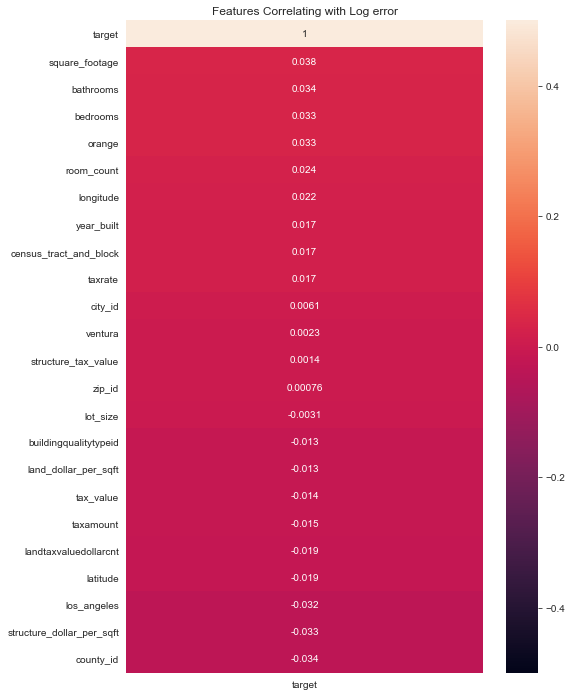

In [7]:
# creating a heatmap to find corralation with the target
# the lighter the color the more corralated the darker the less corralated
explore.zillow_heatmap(train)

**Heatmap Takeaways**
- Top 3 positively corralated:
    - Square footage
    - Bathrooms
    - Bedrooms
    
- Top 3 negatively corralated:
    - county id
    - structure price
    - los angeles county

##### Univariate

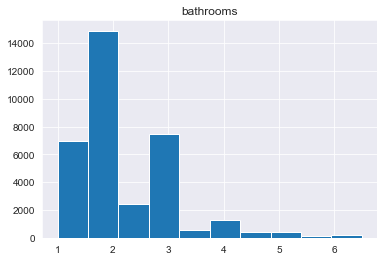

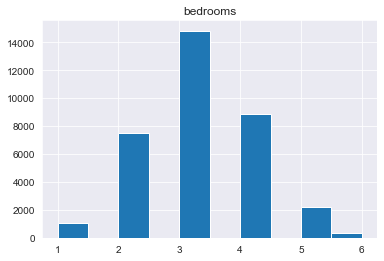

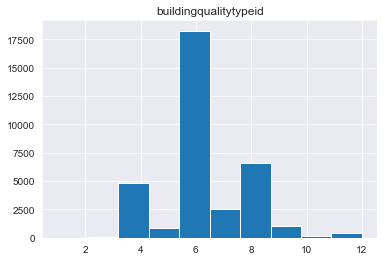

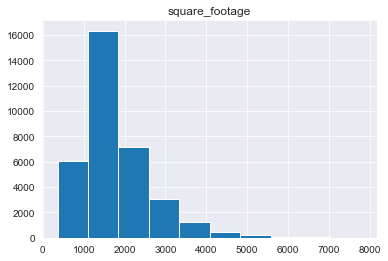

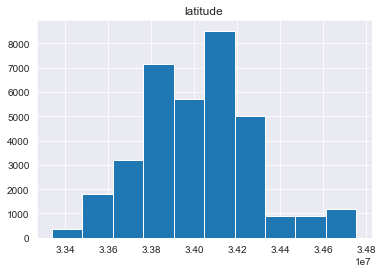

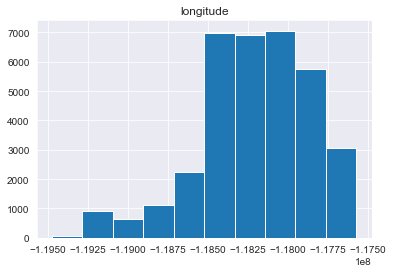

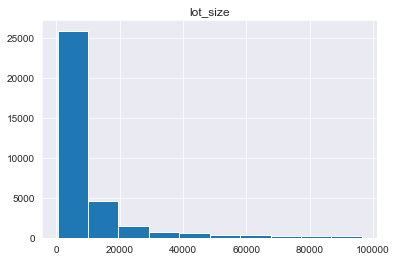

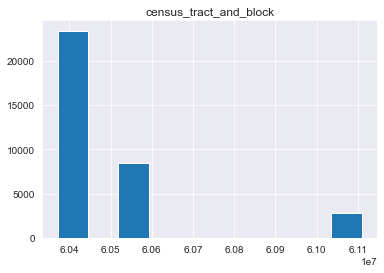

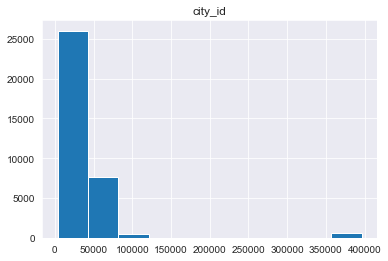

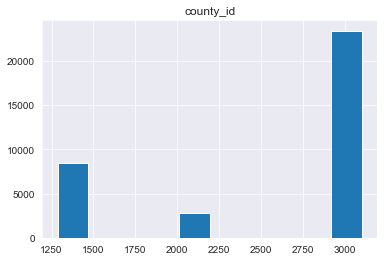

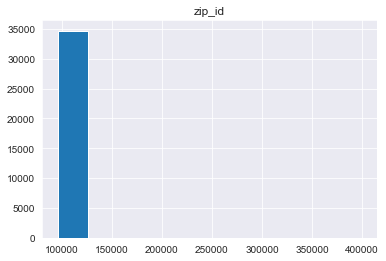

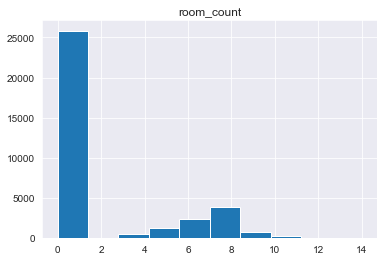

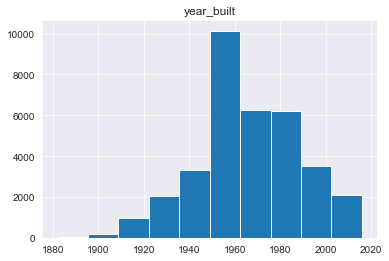

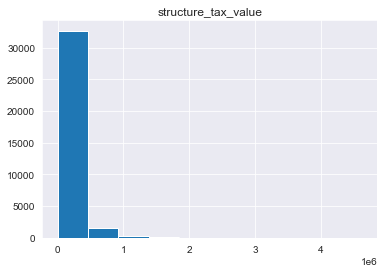

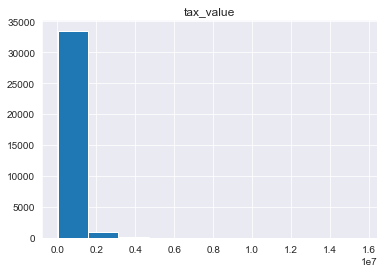

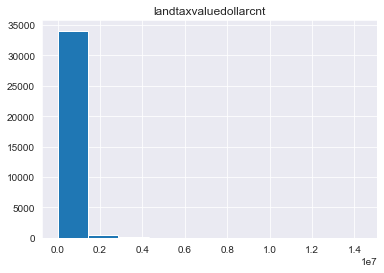

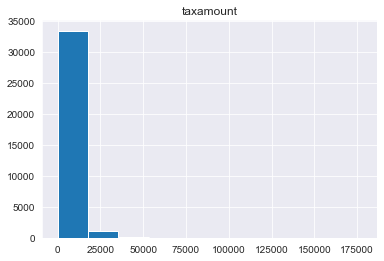

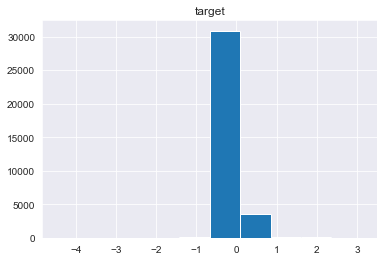

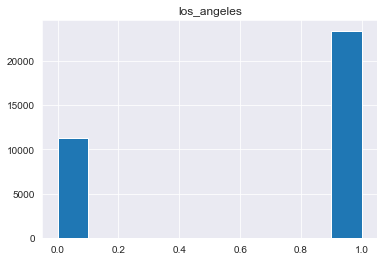

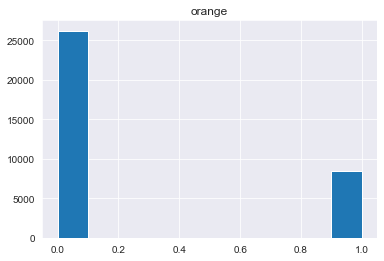

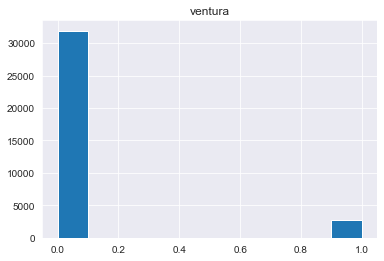

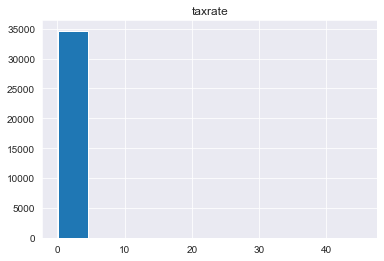

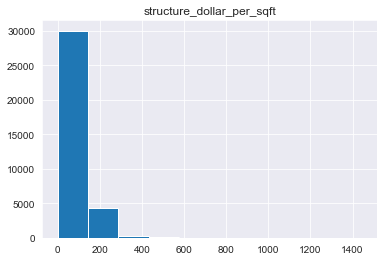

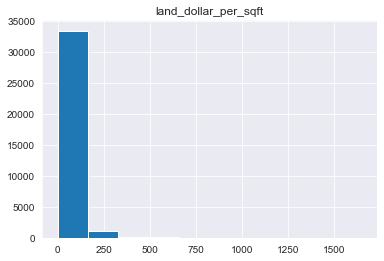

In [8]:
# plotting the distribution for all of my columns in histograms
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

Summary Statistics for square_footage 
count    34719.00000
mean      1796.18981
std        868.39551
min        360.00000
25%       1212.00000
50%       1567.00000
75%       2144.00000
max       7812.00000
Name: square_footage, dtype: float64
Summary Statistics for bathrooms 
count    34719.000000
mean         2.253694
std          0.920503
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          6.500000
Name: bathrooms, dtype: float64
Summary Statistics for bedrooms 
count    34719.000000
mean         3.133644
std          0.951014
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: bedrooms, dtype: float64


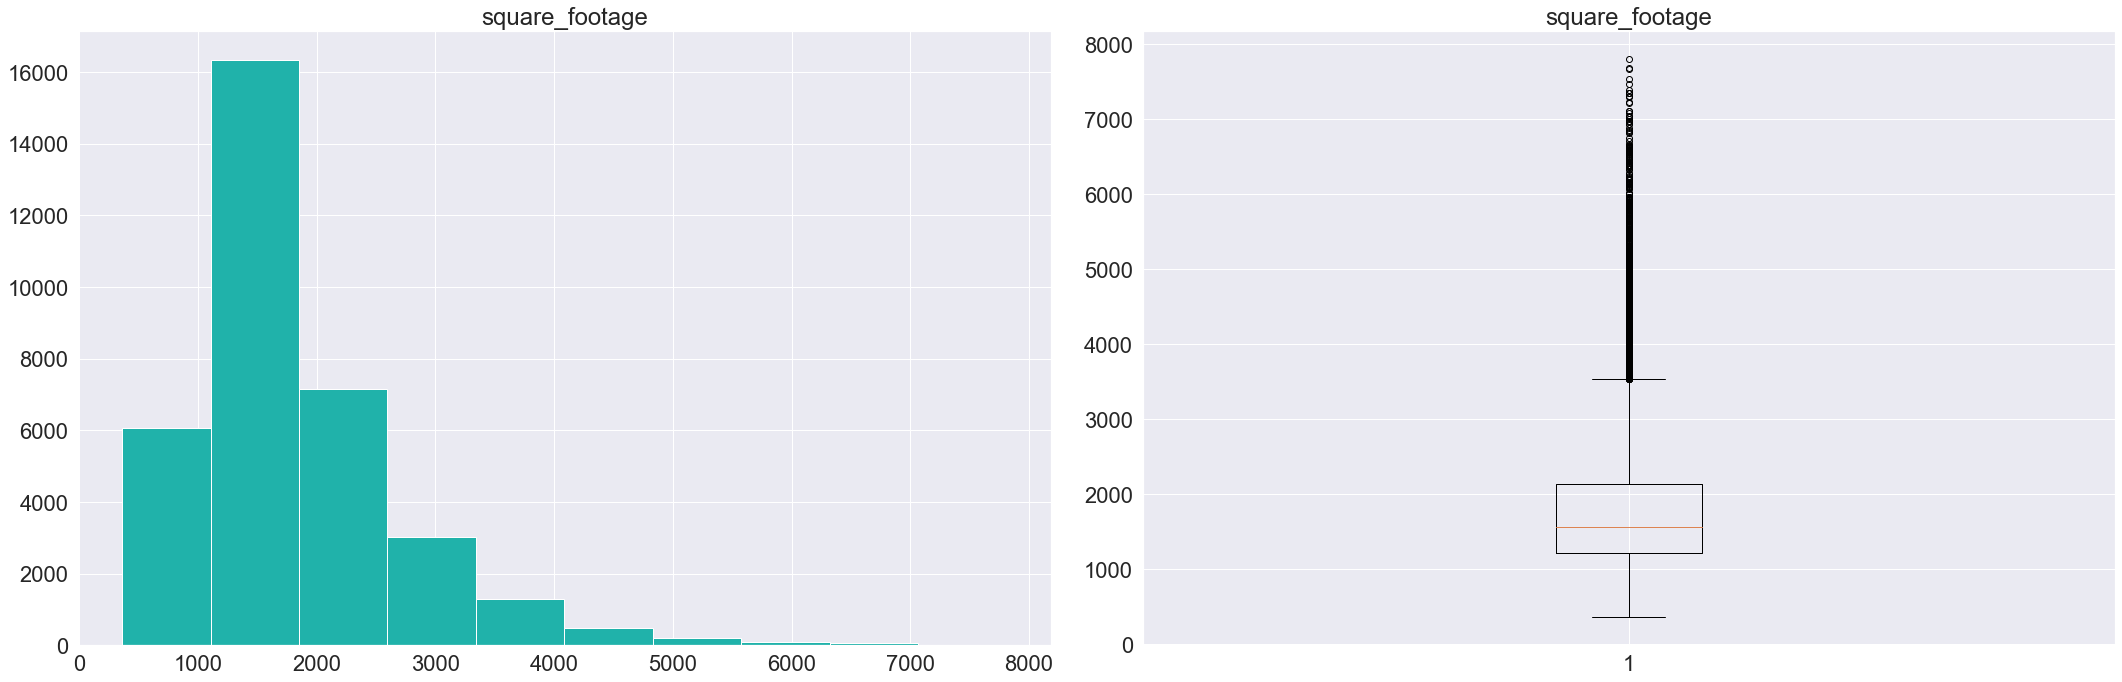

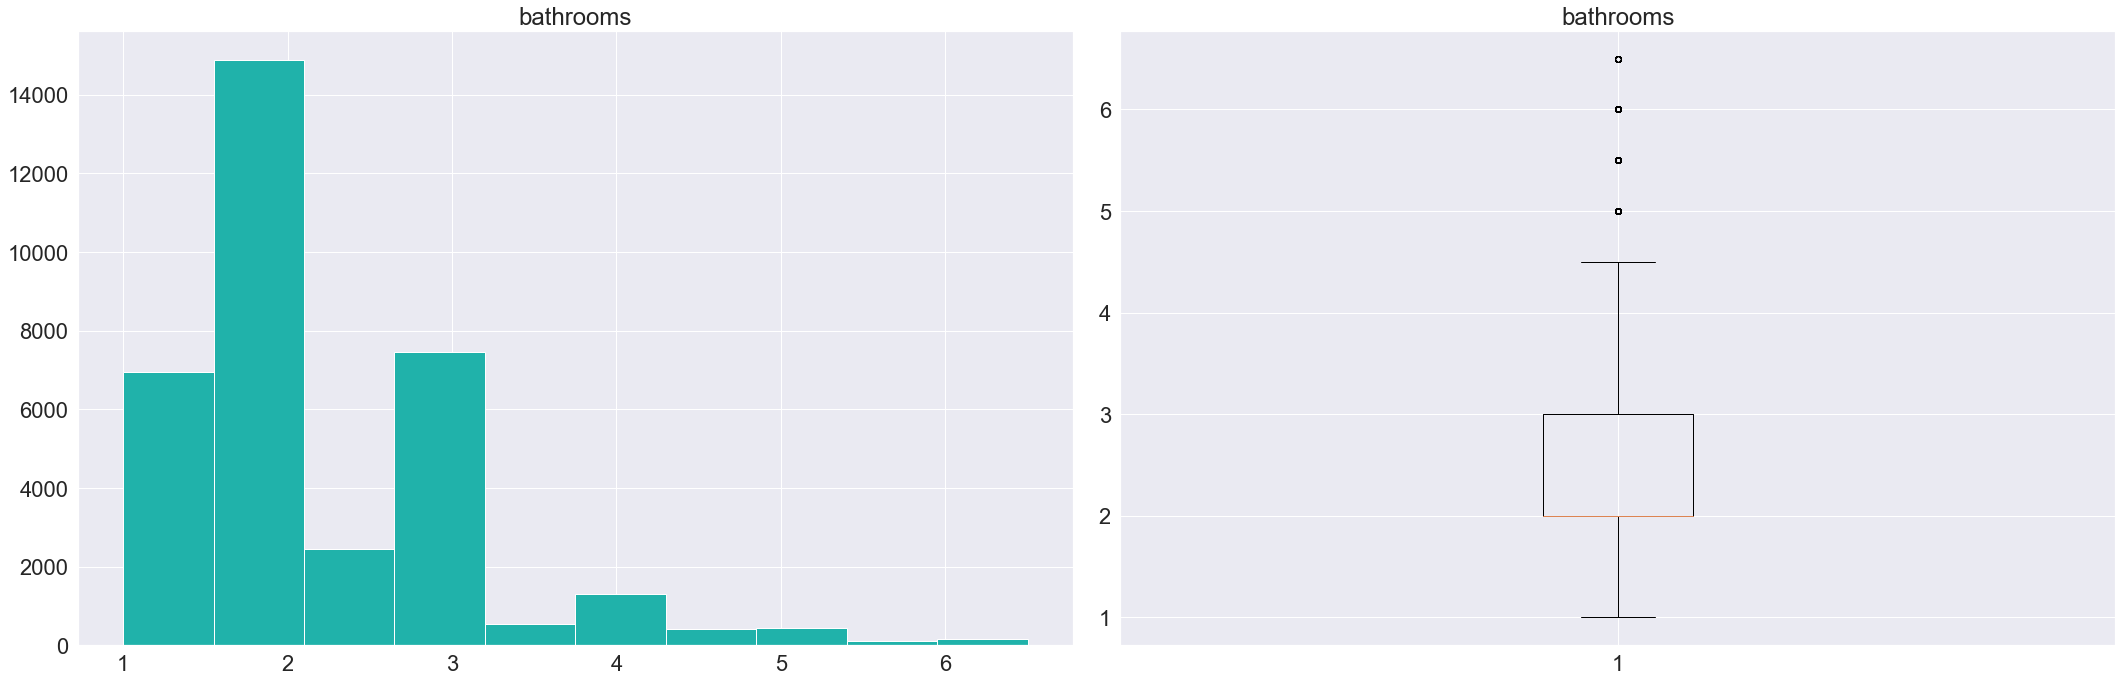

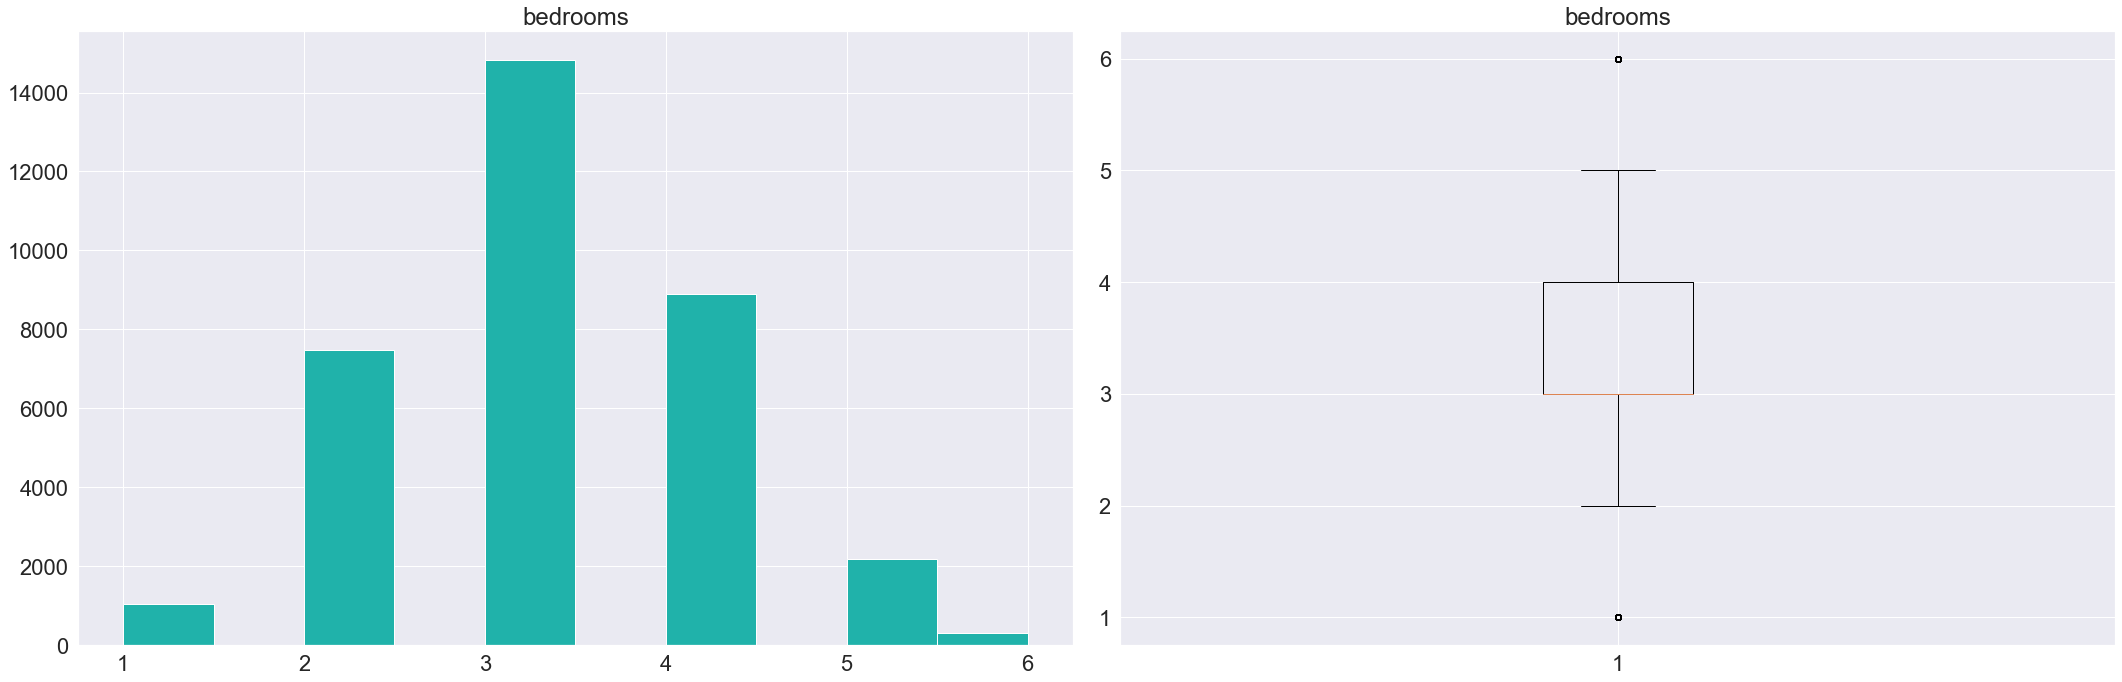

In [9]:
# lets look more closely at the top 3 that are positively correlated with log error
positive_top_3 = ["square_footage","bathrooms","bedrooms"]
for _ in positive_top_3:
    p,statistics = explore.explore_univariate_quant(train,_)
    print(f"Summary Statistics for {_} \n{statistics}")

Summary Statistics for county_id
count    34719.000000
mean      2572.338748
std        783.986871
min       1286.000000
25%       2061.000000
50%       3101.000000
75%       3101.000000
max       3101.000000
Name: county_id, dtype: float64
Summary Statistics for structure_tax_value
count    3.471900e+04
mean     1.831648e+05
std      1.902262e+05
min      1.480000e+02
25%      7.971950e+04
50%      1.320300e+05
75%      2.164510e+05
max      4.623607e+06
Name: structure_tax_value, dtype: float64
Summary Statistics for los_angeles
count    34719.000000
mean         0.674069
std          0.468728
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: los_angeles, dtype: float64


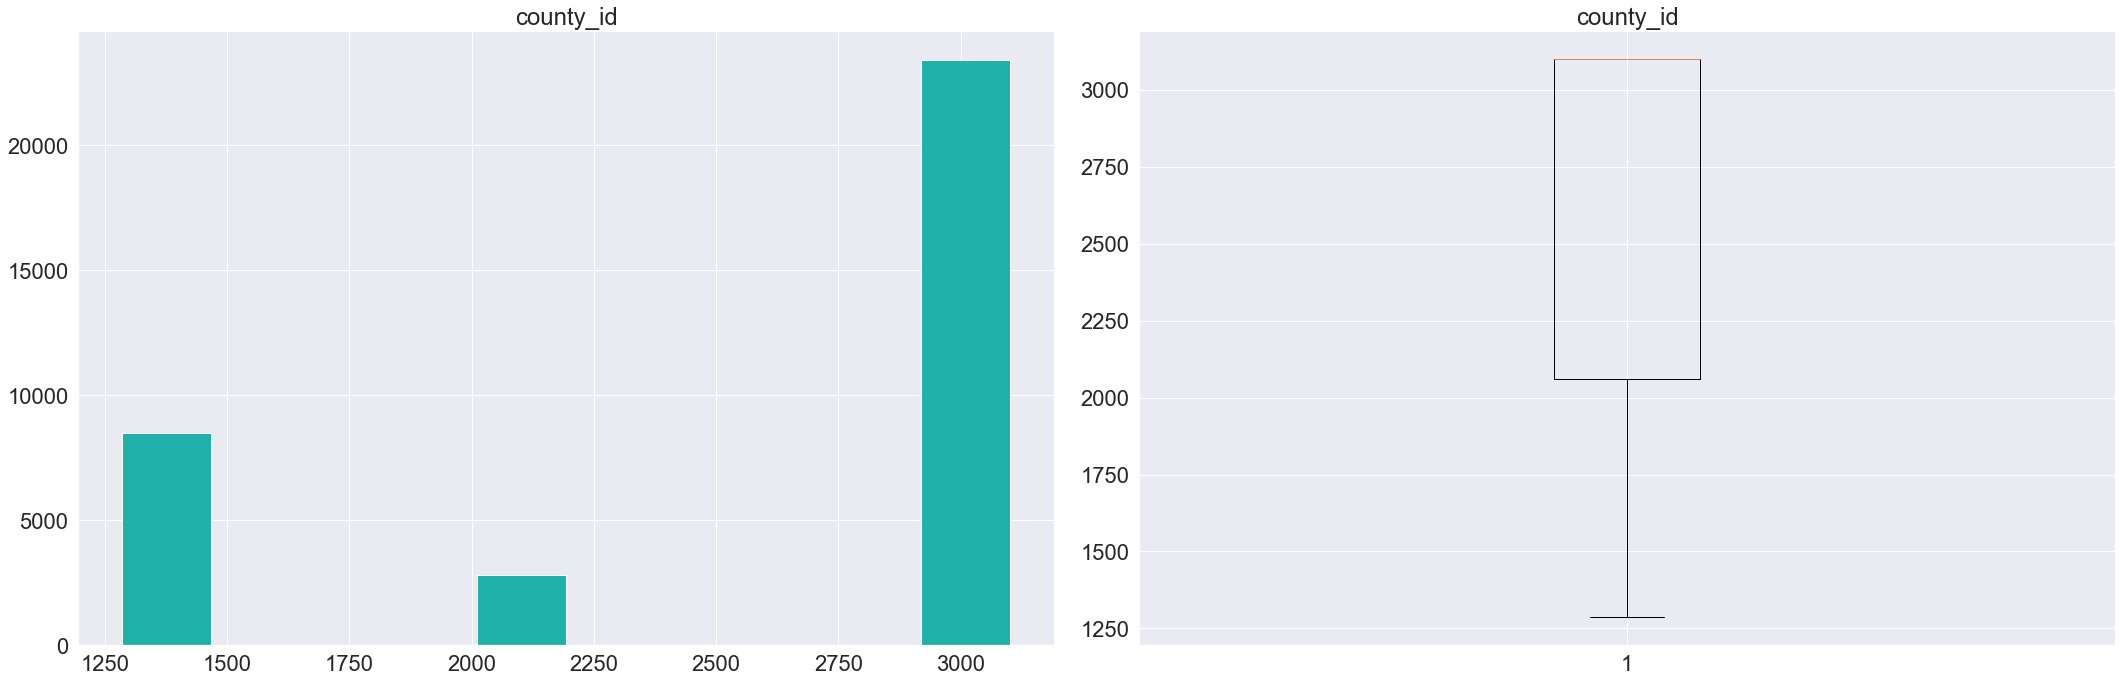

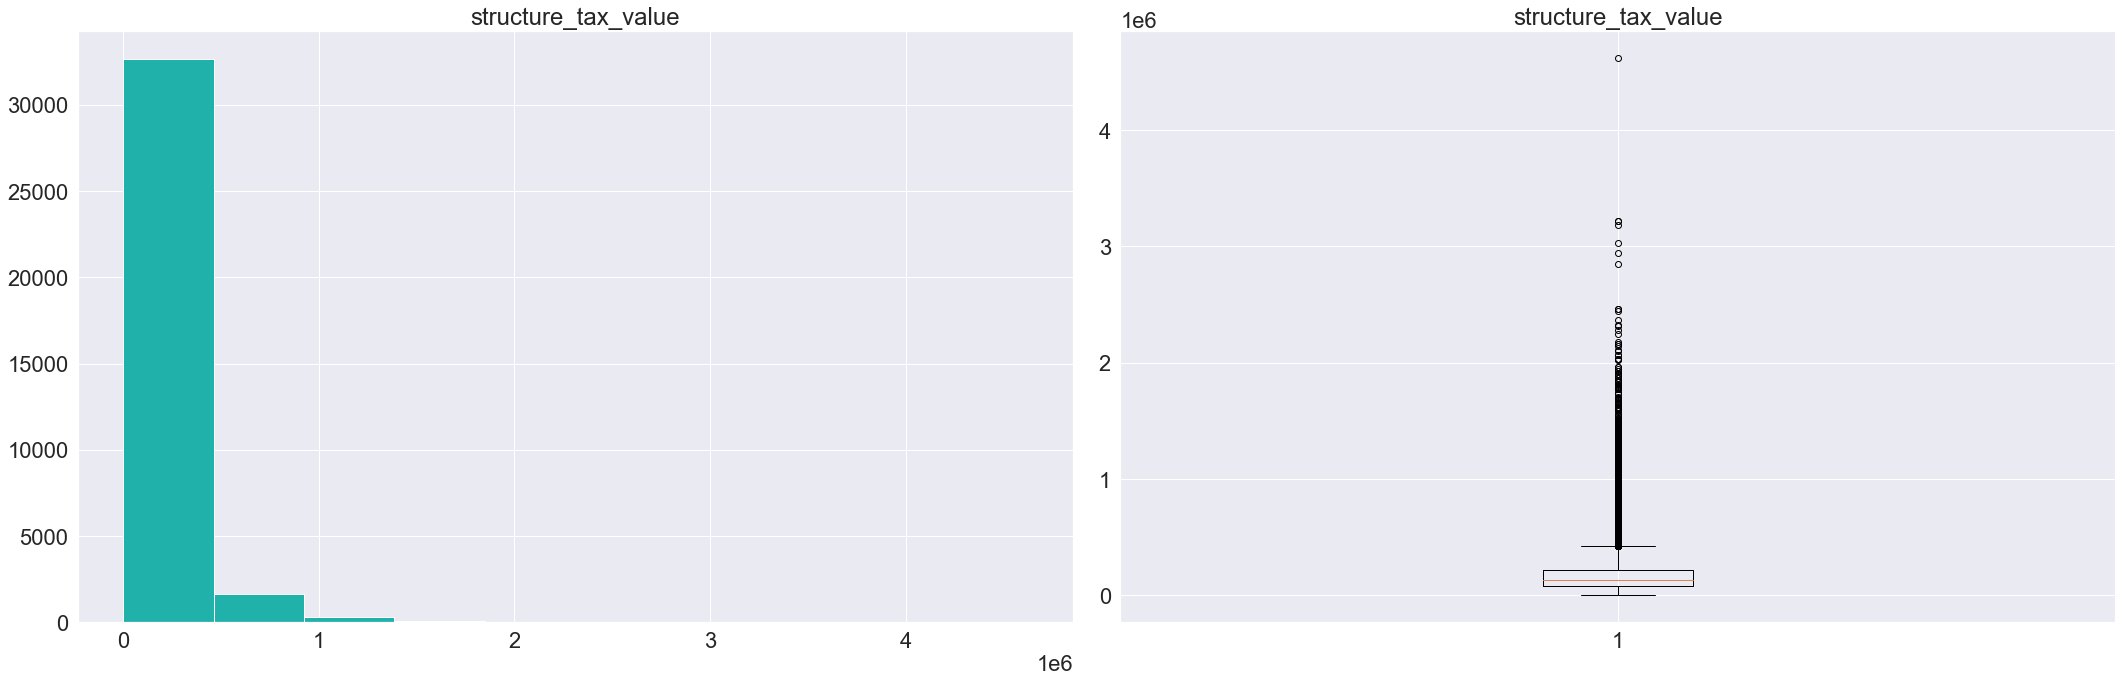

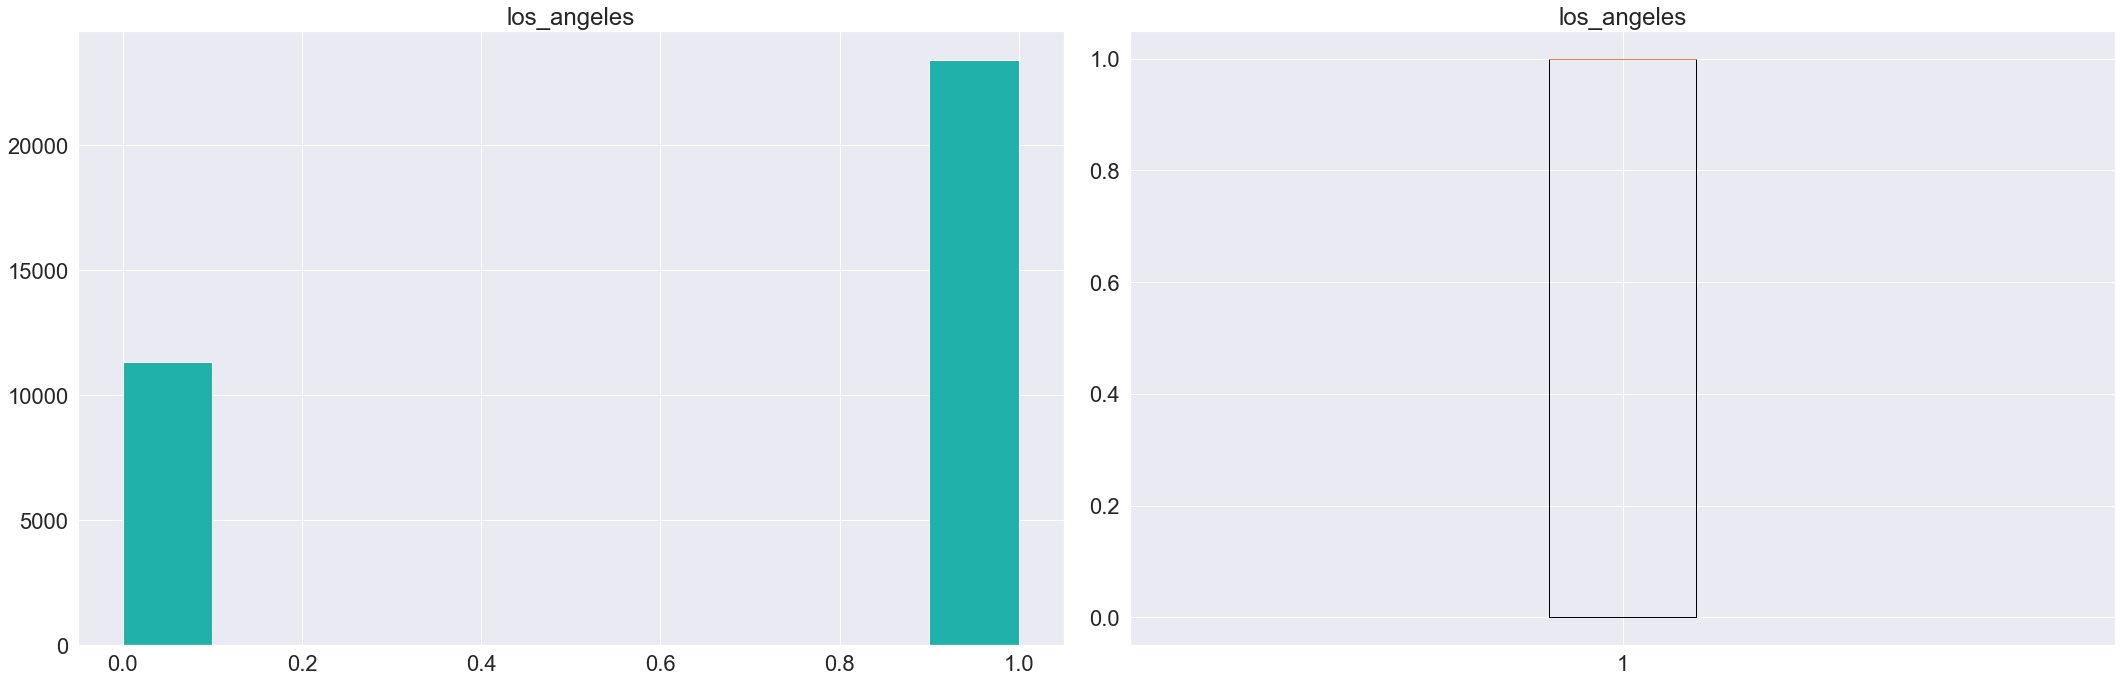

In [10]:
# lets look more closely at the top 3 that are negatively correlated with log error
negative_top_3 = ["county_id","structure_tax_value","los_angeles"]
for _ in negative_top_3:
    p,statistics = explore.explore_univariate_quant(train,_)
    print(f"Summary Statistics for {_}\n{statistics}")

**Univariate Takeaways**
- Normal distributions:
    - bedrooms
    - latitude
    - year built
- Right skewed:
    - bathrooms
    - tax amount
    - structure tax amount
    - tax value
- Left skewed:
    - longitude

Some of the graphs give incite but doesnt give the information needed for documentation

##### Bivariate and hypothesis testing

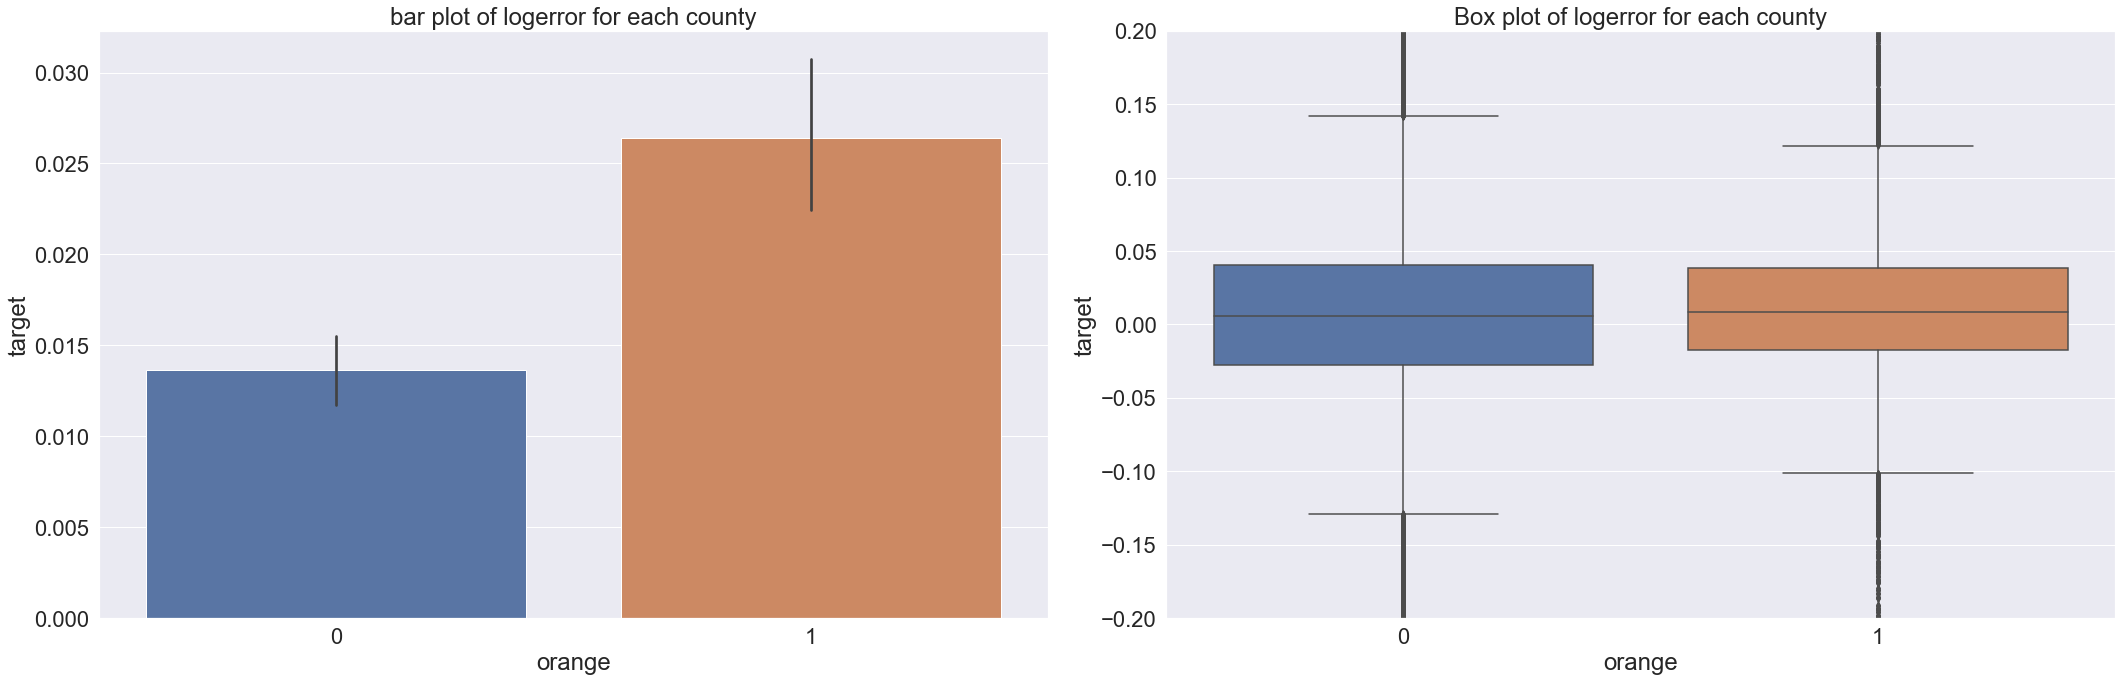

In [11]:
# lets look at the relationship of logerror and orange county
explore.logerror_county(train,x = "orange")

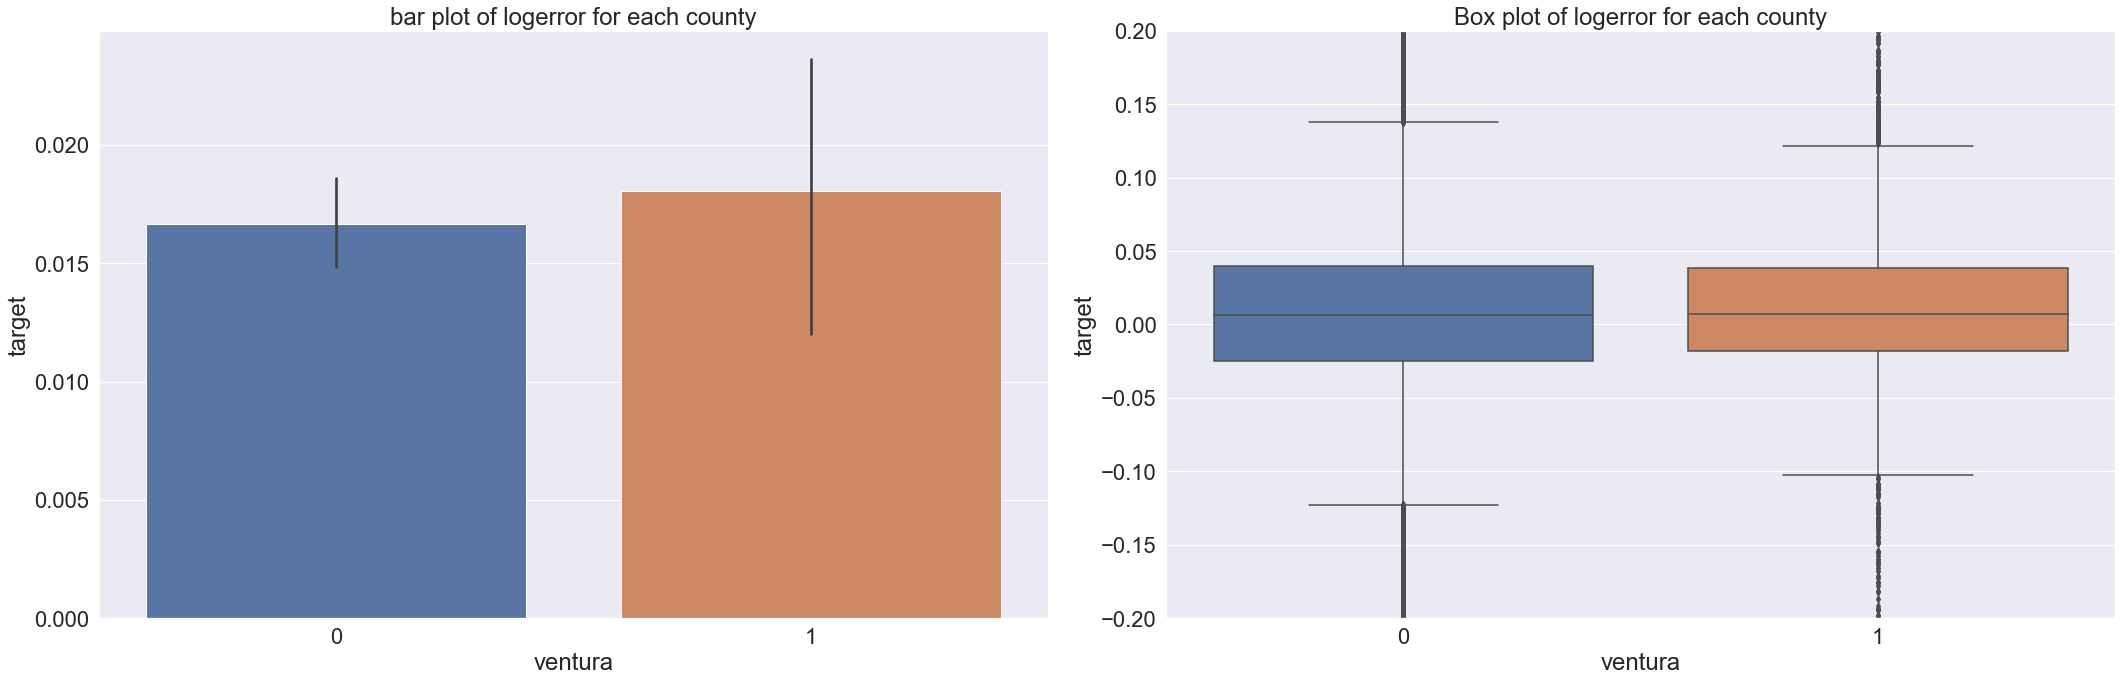

In [12]:
# now lets look at ventura
explore.logerror_county(train,x = "ventura")

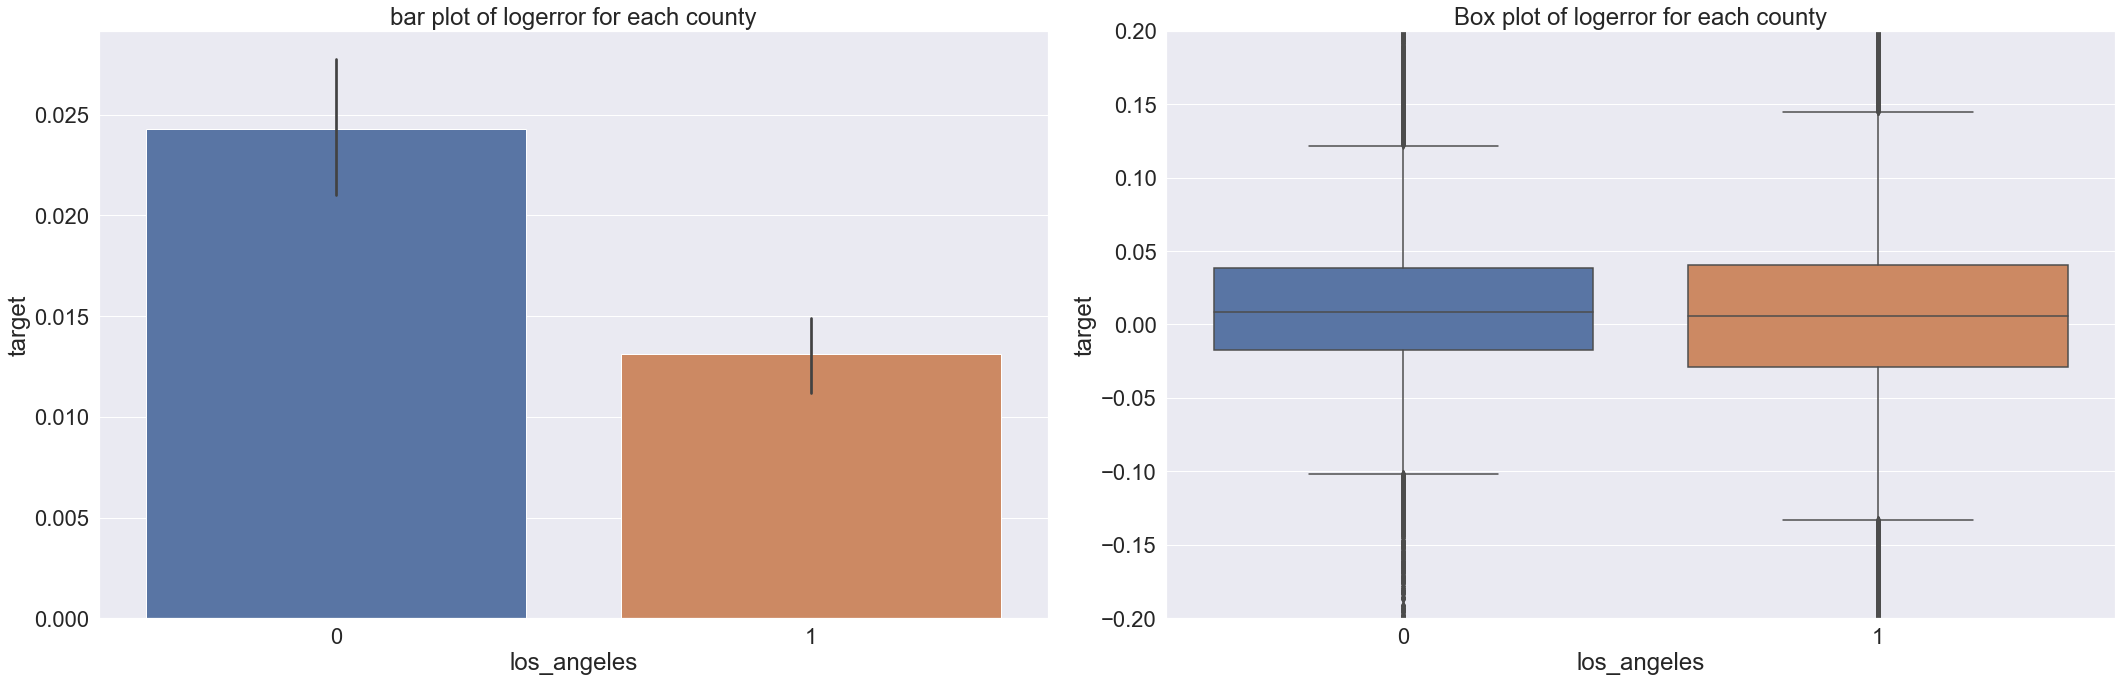

In [13]:
# now los angeles
explore.logerror_county(train,x = "los_angeles")

In [14]:
# Orange and los angeles had the largest difference so lets use a statistical test to see if they really are different
null_hypothesis = "There is no difference in log error between orange county and los angeles county"
alternative_hypothesis = "There is a difference in log error between orange county and los angeles county"

orange_county = train[train.orange == 1]
los_angeles_county = train[train.los_angeles == 1]
t,p = stats.ttest_ind(los_angeles_county.target,orange_county.target)
print(f"p-value{p}")
print("-----------")
if p < α:
    print(f"We reject the null hypothesis that: {null_hypothesis}.")
    print(f"There is evidence to suggest that: {alternative_hypothesis}.")
else:
    print(f"We failed to reject the null hypothesis that: {null_hypothesis}.")

p-value2.993721113015748e-10
-----------
We reject the null hypothesis that: There is no difference in log error between orange county and los angeles county.
There is evidence to suggest that: There is a difference in log error between orange county and los angeles county.


**Takeaways**
- We rejected the null
- There is a difference in log error between orange county and los angeles

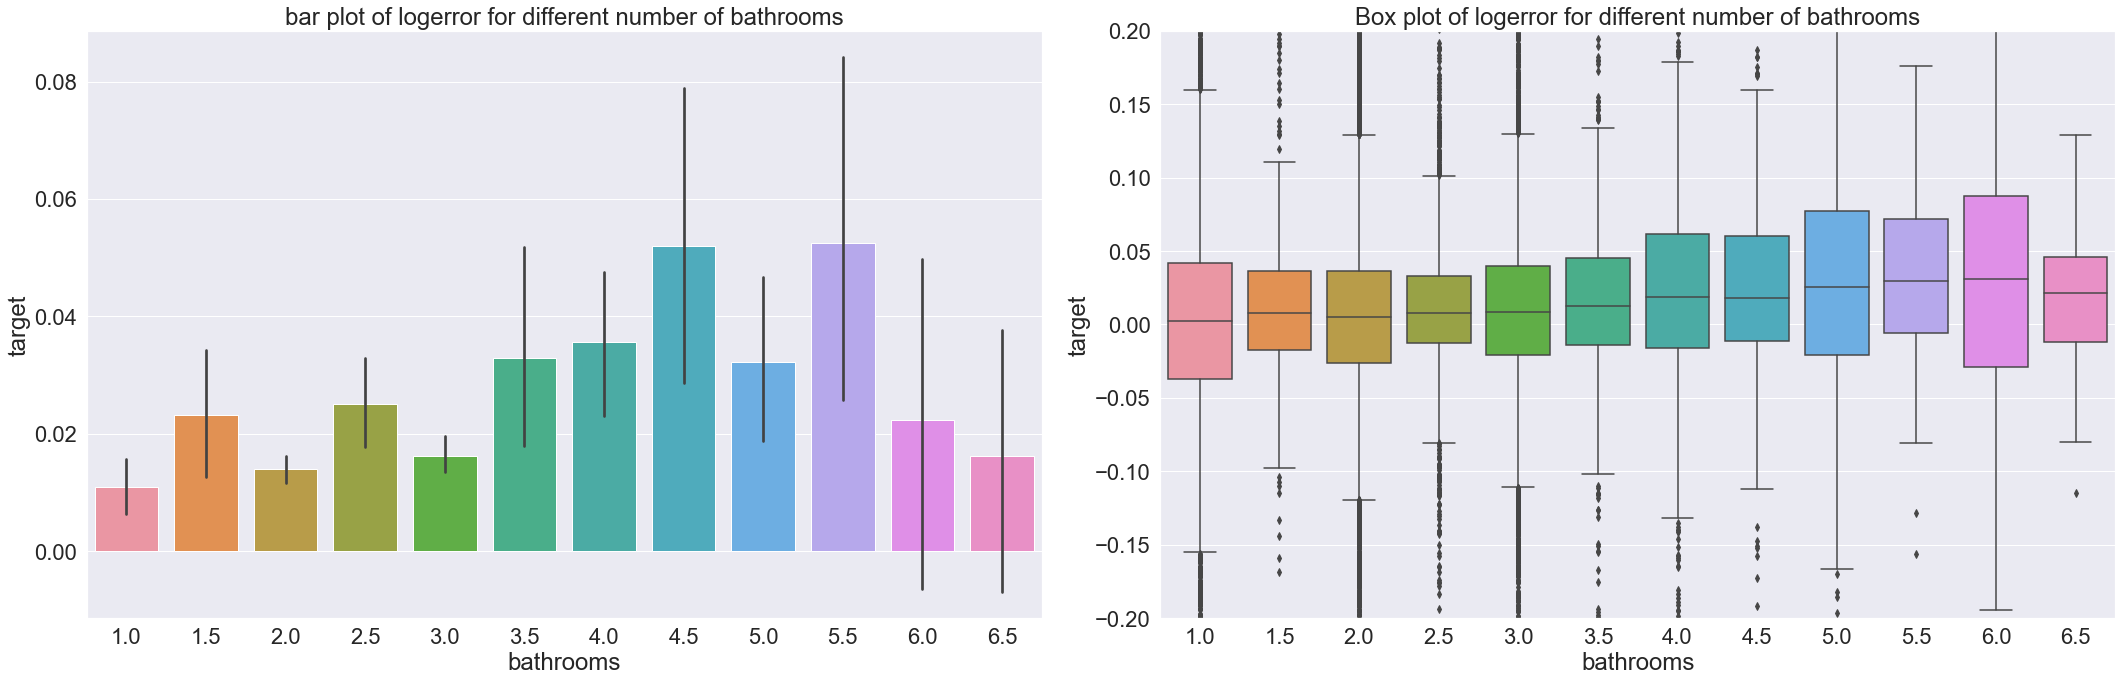

In [15]:
# Visualization of log error with the different bathroom counts
explore.logerror_bathrooms(train)

In [16]:
# Lets test if there is a relationship
null_hypothesis = "There is no relationship between log error and number of bathrooms"
alternative_hypothesis = "There is a relationship between log error and number of bathrooms"

r, p = stats.pearsonr(train.bathrooms,train.target)
print(f"p-value{p}")
print("-----------")
if p < α:
    print(f"We reject the null hypothesis that: {null_hypothesis}.")
    print(f"There is evidence to suggest that: {alternative_hypothesis}.")
else:
    print(f"We failed to reject the null hypothesis that: {null_hypothesis}.")

p-value3.9351350788691955e-10
-----------
We reject the null hypothesis that: There is no relationship between log error and number of bathrooms.
There is evidence to suggest that: There is a relationship between log error and number of bathrooms.


**Takeaways**
- We rejected the null
- There is a relationship between log error and number of bathrooms

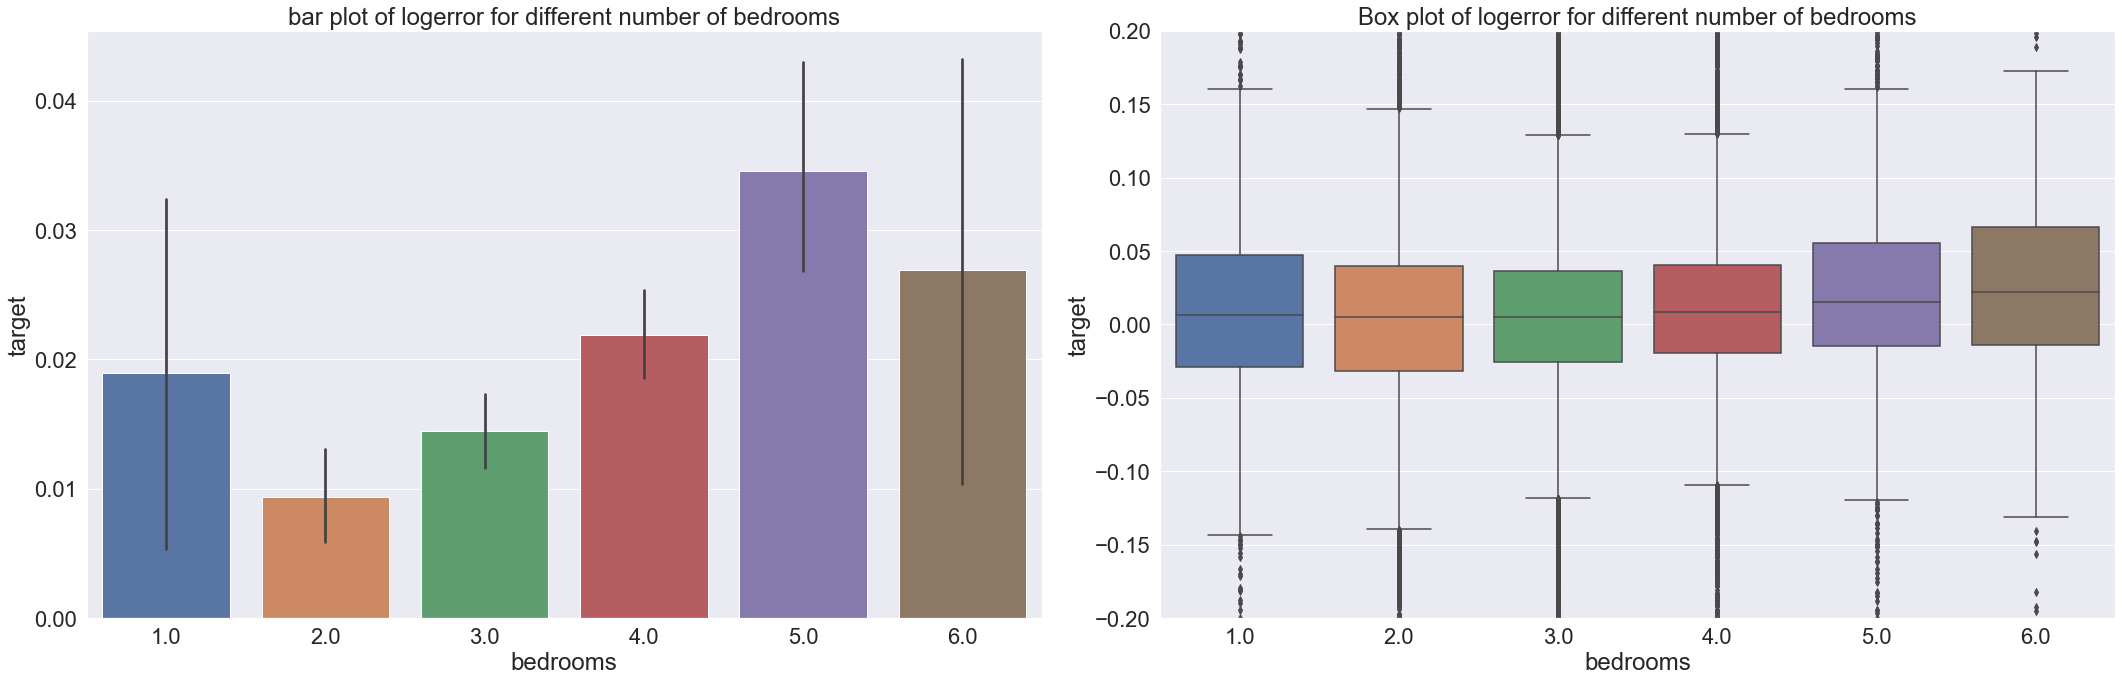

In [17]:
# visualization of log error with the different bedroom counts.
explore.logerror_bedrooms(train)

In [18]:
# lets test to see if there is a relationship
null_hypothesis = "There is no relationship between log error and number of bedrooms"
alternative_hypothesis = "There is a relationship between log error and number of bedrooms"

r, p = stats.pearsonr(train.bedrooms,train.target)
print(f"p-value{p}")
print("-----------")
if p < α:
    print(f"We reject the null hypothesis that: {null_hypothesis}.")
    print(f"There is evidence to suggest that: {alternative_hypothesis}.")
else:
    print(f"We failed to reject the null hypothesis that: {null_hypothesis}.")

p-value4.629637022259538e-10
-----------
We reject the null hypothesis that: There is no relationship between log error and number of bedrooms.
There is evidence to suggest that: There is a relationship between log error and number of bedrooms.


**Takeaways**
- We rejected the null
- There is a relationship between log error and number of bedrooms

In [19]:
# splitting the lots by the median to get two groups, large and small lots.
large_lot = train[train.lot_size <= 7100].target
small_lot = train[train.lot_size > 7100].target

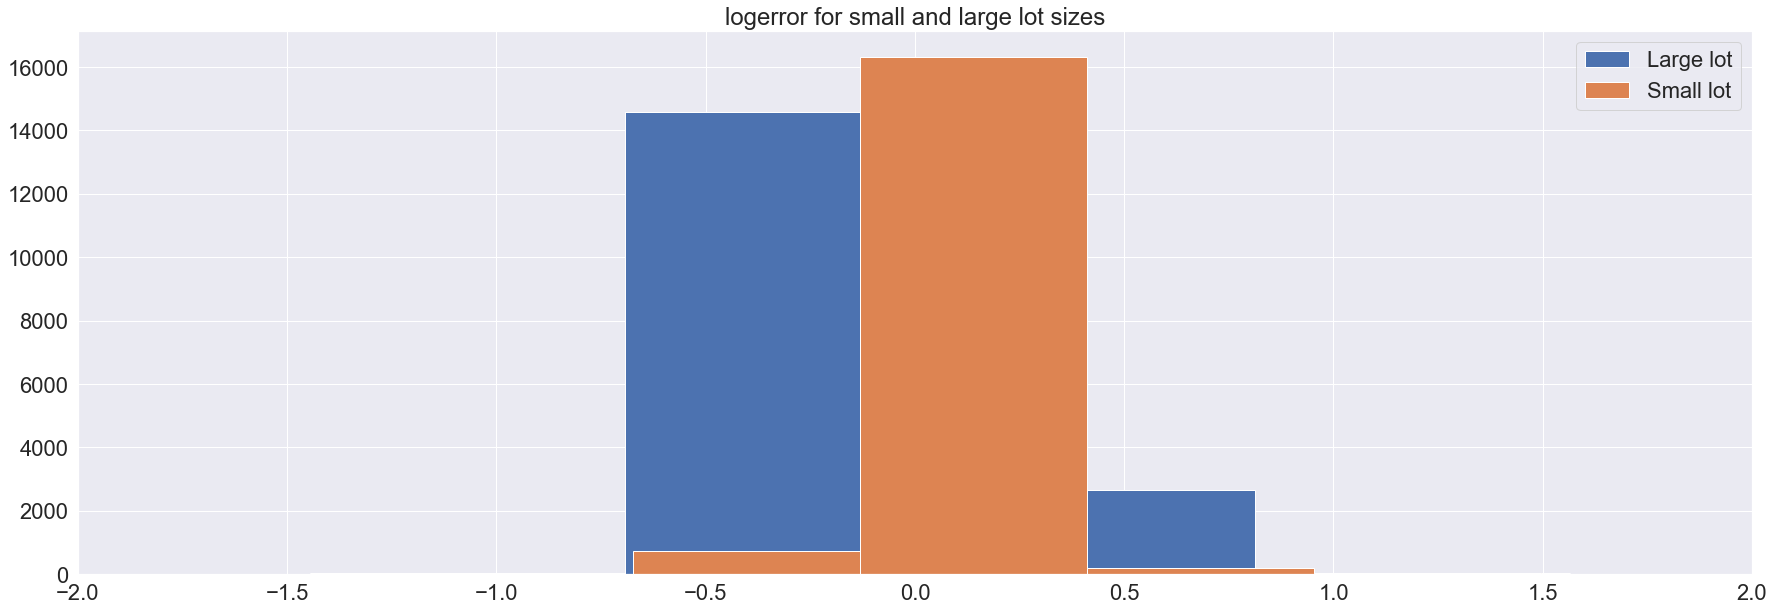

In [20]:
# plotting the log error of the two groups
plt.figure(figsize = (30,10))
sns.set(font_scale = 2)
plt.hist(large_lot, label = "Large lot")
plt.hist(small_lot, label = "Small lot")
plt.legend()
plt.xlim(-2,2)
plt.title("logerror for small and large lot sizes")
plt.show()

In [21]:
# lets test to see if there is a significant difference between the large and small lots.
null_hypothesis = "There is no difference in log error between large lots and small lots"
alternative_hypothesis = "There is a difference in log error between large lots and small lots"

t,p = stats.ttest_ind(large_lot,small_lot)
print(f"p-value{p}")
print("-----------")
if p < α:
    print(f"We reject the null hypothesis that: {null_hypothesis}.")
    print(f"There is evidence to suggest that: {alternative_hypothesis}.")
else:
    print(f"We failed to reject the null hypothesis that: {null_hypothesis}.")

p-value0.040037055429733084
-----------
We reject the null hypothesis that: There is no difference in log error between large lots and small lots.
There is evidence to suggest that: There is a difference in log error between large lots and small lots.


**Takeaways**
- We rejected the null
- There is a difference in log error between large and small lots
- Large lots seem to mostly land slightly negative, while small lots seem to be slightly positive

In [22]:
# again splitting square footage into two groups using the median
large_unit = train[train.square_footage <= 1550].target
small_unit = train[train.square_footage > 1550].target

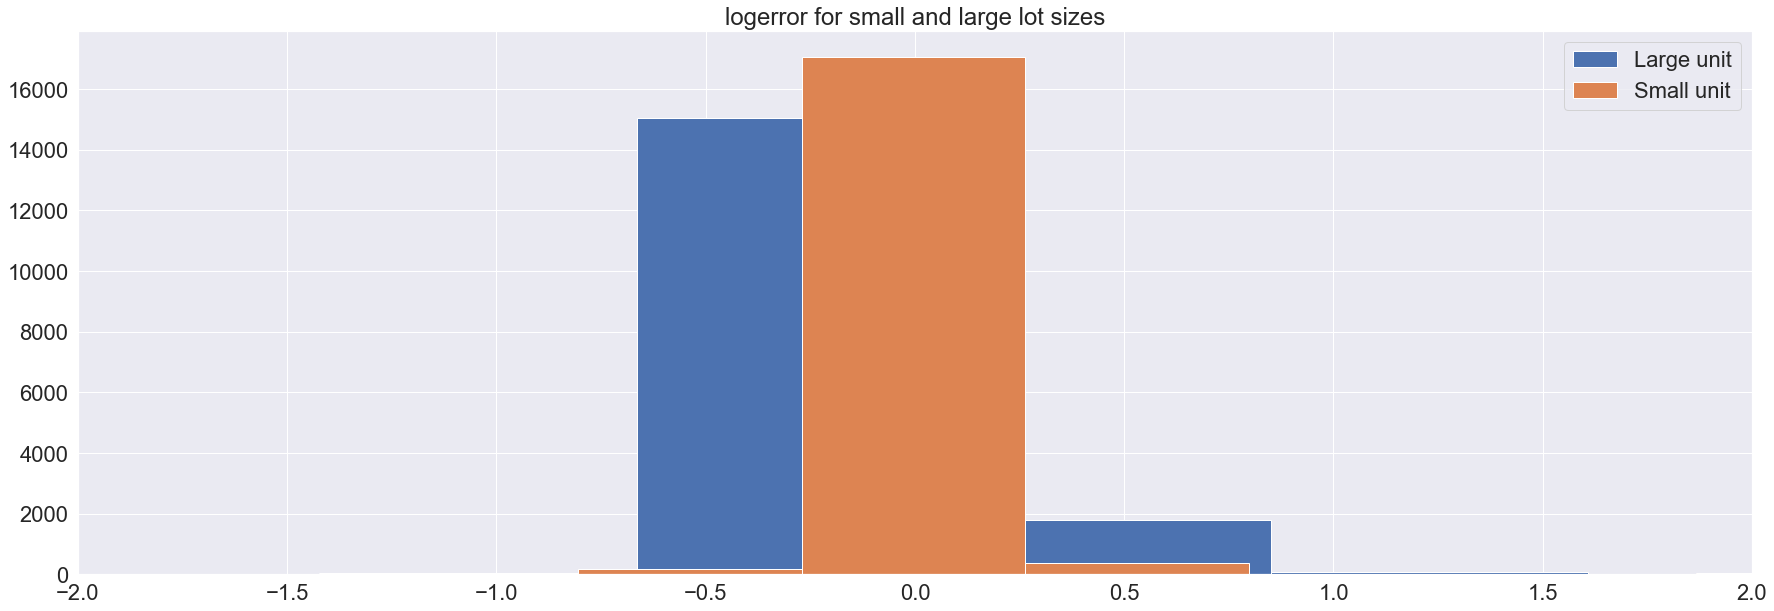

In [23]:
# plotting the two groups log error on a joint histogram
plt.figure(figsize = (30,10))
sns.set(font_scale = 2)
plt.hist(large_unit, label = "Large unit")
plt.hist(small_unit, label = "Small unit")
plt.legend()
plt.xlim(-2,2)
plt.title("logerror for small and large lot sizes")
plt.show()

In [24]:
# lets see if there is a difference in log error between the two 
null_hypothesis = "There is no difference in log error between large units and small units"
alternative_hypothesis = "There is a difference in log error between large units and small units"

t,p = stats.ttest_ind(large_unit,small_unit)
print(f"p-value{p}")
print("-----------")
if p < α:
    print(f"We reject the null hypothesis that: {null_hypothesis}.")
    print(f"There is evidence to suggest that: {alternative_hypothesis}.")
else:
    print(f"We failed to reject the null hypothesis that: {null_hypothesis}.")

p-value0.00035045466174726006
-----------
We reject the null hypothesis that: There is no difference in log error between large units and small units.
There is evidence to suggest that: There is a difference in log error between large units and small units.


**Takeaways**
- We rejected the null
- There is a difference in log error between large and small lots
- Large units seem to mostly be slightly lower for log error, while small units seem to be slightly higher

In [25]:
# lets make a pairplot im going to bin the log error so the pairplot is more readable
train["logerror_bins"] = pd.cut(train.target, [-6,-.7,-.2,.2,.7,6])

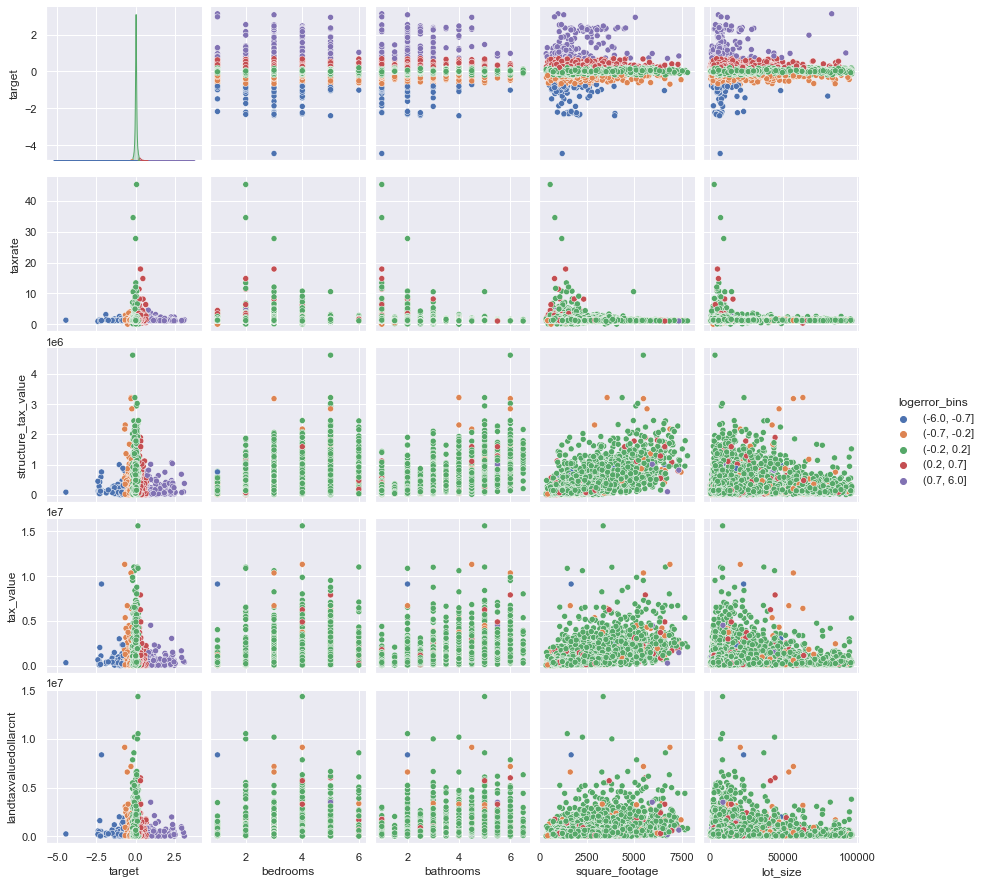

In [26]:
# Making the thing
sns.set(font_scale = 1)
sns.pairplot(data = train, hue = "logerror_bins",
             x_vars = ["target","bedrooms","bathrooms","square_footage","lot_size"],
             y_vars = ["target","taxrate","structure_tax_value","tax_value","landtaxvaluedollarcnt"])

**Takeaways**
- The statistical testing showed there is a relationship between bedrooms, bathroom to log error.
- The testing also showed a difference in log error between:
    - orange county and los angeles county
    - large lots and small lots
    - large units and small units

- The heatmap showed very low corralation for our variables.
- There are a tun of incites that I did not have time to get out of the data, but out exploration gave us valuable information.

##### Clustering

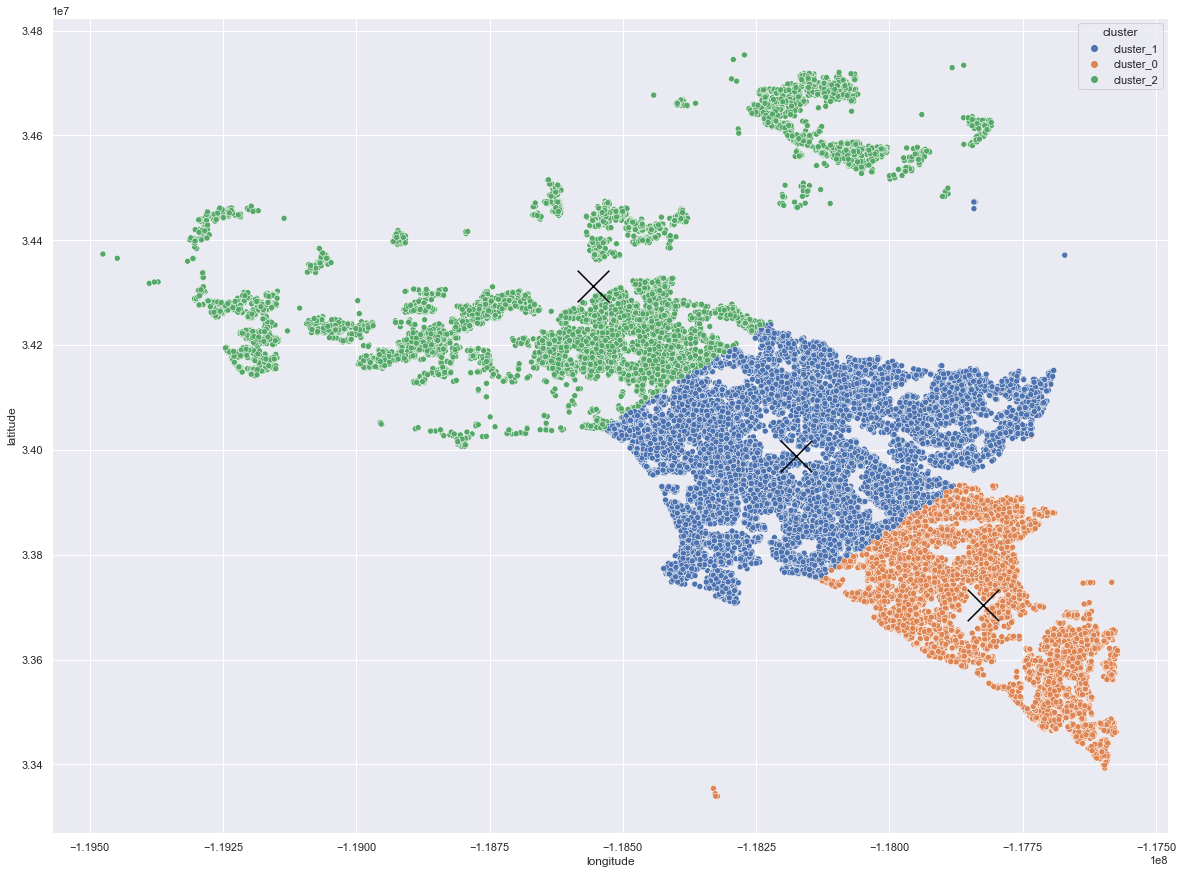

In [27]:
# Lets cluster by location were going to try 3 clusters since we know that there are 3 counties
X = train[["longitude","latitude"]]
train, X_scaled, scaler, kmeans, centroids = explore.create_cluster(train,X, 3)
plt.figure(figsize = (20,15))
sns.scatterplot(data = train, x = "longitude",y = "latitude", hue = "cluster")
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),columns = X_scaled.columns)
centroids.plot.scatter(x = "longitude", y = "latitude",ax = plt.gca(), c = "black", marker = "x", s = 1000)
plt.show()

In [28]:
cluster_0 = train[train.cluster == "cluster_0"].target
cluster_1 = train[train.cluster == "cluster_1"].target
cluster_2 = train[train.cluster == "cluster_2"].target

In [29]:
cluster_0.mean()

0.026963169378975693

In [30]:
cluster_1.mean()

0.012286444322750365

In [31]:
cluster_2.mean()

0.016157569848946122

In [32]:
null_hypothesis = "There is no difference in log error based on the latitude and longitude clusters"
alternative_hypothesis = "There is a difference in log error based on the latitude and longitude clusters"

f, p = kruskal(cluster_0,cluster_1,cluster_2)
print(f"p-value:{p}")
print("-----------------------------")
if p < α:
    print(f"We reject the null hypothesis that: {null_hypothesis}.")
    print(f"There is evidence to suggest that: {alternative_hypothesis}.")
else:
    print(f"We failed to reject the null hypothesis that: {null_hypothesis}.")

p-value:5.8119872682468e-11
-----------------------------
We reject the null hypothesis that: There is no difference in log error based on the latitude and longitude clusters.
There is evidence to suggest that: There is a difference in log error based on the latitude and longitude clusters.


**Takeaways**
- There does seem to be some difference in log error between the clusters which is similar to our county clusters where we found similar results

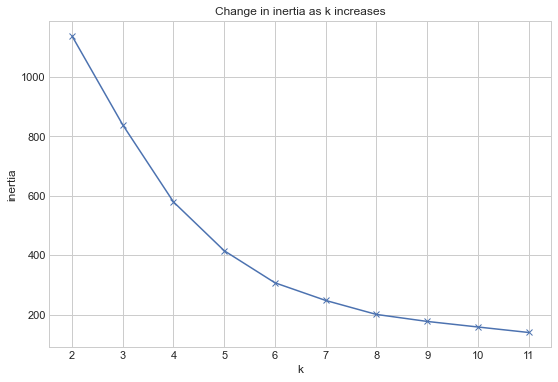

In [33]:
# plotting the inertia with different k values
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [34]:
# Lets try to add another cluster variable to see if we can get better results

In [35]:
# We are also going to try to use a different algorithm (elken)
X = train[["longitude","latitude","square_footage"]]
train, X_scaled, scaler, kmeans, centroids = explore.create_cluster_elkan(train,X, 4)

In [36]:
train.cluster.value_counts()

cluster_0    16203
cluster_1     8407
cluster_2     8036
cluster_3     2073
Name: cluster, dtype: int64

In [37]:
# Getting the lorgerror from each cluster
cluster_0 = train[train.cluster == "cluster_0"].target
cluster_1 = train[train.cluster == "cluster_1"].target
cluster_2 = train[train.cluster == "cluster_2"].target
cluster_3 = train[train.cluster == "cluster_3"].target

In [38]:
cluster_0.mean()

0.011947850188788831

In [39]:
cluster_1.mean()

0.016383499909960915

In [40]:
cluster_2.mean()

0.02798572252602483

In [41]:
cluster_3.mean()

0.012514508968797612

**A K of 4-5 seems to be what we should aim for**

In [42]:
null_hypothesis = "There is no difference in log error based on the latitude longitude, and square footage clusters"
alternative_hypothesis = "There is a difference in log error based on the latitude and longitude and square footage clusters"

f, p = kruskal(cluster_0,cluster_1,cluster_2,cluster_3)
print(f"p-value:{p}")
print("-----------------------------")
if p < α:
    print(f"We reject the null hypothesis that: {null_hypothesis}.")
    print(f"There is evidence to suggest that: {alternative_hypothesis}.")
else:
    print(f"We failed to reject the null hypothesis that: {null_hypothesis}.")

p-value:1.6886679091792466e-24
-----------------------------
We reject the null hypothesis that: There is no difference in log error based on the latitude longitude, and square footage clusters.
There is evidence to suggest that: There is a difference in log error based on the latitude and longitude and square footage clusters.


In [43]:
# Lets try brand new variables to see if it can improve compared to our current cluster

In [44]:
# lets try using some basic information about the house and try to cluster that way
X = train[["bathrooms","bedrooms","tax_value"]]
train, X_scaled, scaler, kmeans, centroids = explore.create_cluster_elkan(train,X, 5)

In [45]:
train.cluster.value_counts()

cluster_1    10805
cluster_0     9032
cluster_2     7441
cluster_4     5190
cluster_3     2251
Name: cluster, dtype: int64

In [46]:
# Getting the log error from each cluster
cluster_0 = train[train.cluster == "cluster_0"].target
cluster_1 = train[train.cluster == "cluster_1"].target
cluster_2 = train[train.cluster == "cluster_2"].target
cluster_3 = train[train.cluster == "cluster_3"].target
cluster_4 = train[train.cluster == "cluster_4"].target

In [47]:
cluster_0.mean()

0.020790309579328686

In [48]:
cluster_1.mean()

0.014043196395871147

In [49]:
cluster_2.mean()

0.010545914336827555

In [50]:
cluster_3.mean()

0.03969719786764489

In [51]:
cluster_4.mean()

0.01441572052122403

In [52]:
null_hypothesis = "There is no difference in log error based on the bathrooms, bedrooms, tax value clusters"
alternative_hypothesis = "There is a difference in log error based on the bathrooms, bedrooms, tax value clusters"

f, p = kruskal(cluster_0,cluster_1,cluster_2,cluster_3,cluster_4)
print(f"p-value:{p}")
print("-----------------------------")
if p < α:
    print(f"We reject the null hypothesis that: {null_hypothesis}.")
    print(f"There is evidence to suggest that: {alternative_hypothesis}.")
else:
    print(f"We failed to reject the null hypothesis that: {null_hypothesis}.")

p-value:1.078485226560528e-46
-----------------------------
We reject the null hypothesis that: There is no difference in log error based on the bathrooms, bedrooms, tax value clusters.
There is evidence to suggest that: There is a difference in log error based on the bathrooms, bedrooms, tax value clusters.


**Lets use the second and third cluster we created*

In [53]:
# Using the second cluster and putting it on our train validate test
X = X_train_scaled[["bathrooms","bedrooms","tax_value"]]
X_val = X_validate_scaled[["bathrooms","bedrooms","tax_value"]]
X_test = X_test_scaled[["bathrooms","bedrooms","tax_value"]]
# make the thing
kmeans = KMeans(n_clusters = 5, algorithm = "elkan")
# fit the thing
kmeans.fit(X)
# use the thing
X_train_scaled["house_basics_cluster"] = kmeans.predict(X)
X_validate_scaled["house_basics_cluster"] = kmeans.predict(X_val)
X_test_scaled["house_basics_cluster"] = kmeans.predict(X_test)

In [54]:
# Using the third cluster and putting it on our train validate test
X = X_train_scaled[["longitude","latitude","square_footage"]]
X_val = X_validate_scaled[["longitude","latitude","square_footage"]]
X_test = X_test_scaled[["longitude","latitude","square_footage"]]
# make the thing
kmeans = KMeans(n_clusters = 5, algorithm = "elkan")
# fit the thing
kmeans.fit(X)
# use the thing
X_train_scaled["loc_sqft_cluster"] = kmeans.predict(X)
X_validate_scaled["loc_sqft_cluster"] = kmeans.predict(X_val)
X_test_scaled["loc_sqft_cluster"] = kmeans.predict(X_test)

Lets see if our clusters are useful

### Feature selection

In [55]:
# looking at the best features for our model
kbest = explore.select_kbest(X_train_scaled,y_train, k = 10)
for k in kbest:
    print(k)

bathrooms
bedrooms
square_footage
latitude
longitude
county_id
room_count
los_angeles
orange
structure_dollar_per_sqft


**Takeaways**
- Our clusters suck! they performed pretty poorly.
- We can try using our clusters in the modeling phase but its not looking to good for the clusters
- TLDR: Clustering is hard
- Top features:
    - bathrooms
    - bedrooms
    - square footage

## Modeling

**Baseline**

In [56]:
# lets make dataframes of our y values so we can append our models for later use.
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [57]:
# lets get the median baseline
logerror_pred_median = y_train.target.median()
y_train['logerror_pred_median'] = logerror_pred_median

In [58]:
# lets get the mean baseline
logerror_pred_mean = y_train.target.mean()
y_train['logerror_pred_mean'] = logerror_pred_mean

In [59]:
# making a dataframe to store all the models for comparison
metric_df_train = pd.DataFrame()

In [60]:
# adding our baseline mean and median to the dataframe
metric_df_train = modeling.make_metric_df_train(y_train.target, y_train.logerror_pred_mean, "mean_baseline", metric_df_train)
metric_df_train = modeling.make_metric_df_train(y_train.target, y_train.logerror_pred_median, "median_baseline", metric_df_train)

In [61]:
# lets see our rmse
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,0.165721,0.0
1,median_baseline,0.166026,0.0


In [62]:
# Features for our model
features = ['bathrooms','bedrooms','square_footage','house_basics_cluster','loc_sqft_cluster']

In [63]:
# Lets select the features we want for modeling
X_train_scaled = X_train_scaled[features]
X_validate_scaled = X_validate_scaled[features]
X_test_scaled = X_test_scaled[features]

In [64]:
# It works!
X_train_scaled.head()

,bathrooms,bedrooms,square_footage,house_basics_cluster,loc_sqft_cluster
49490,0.181818,0.4,0.088701,3,0
2722,0.272727,0.4,0.126141,1,3
69378,0.454545,0.6,0.498926,4,2
73849,0.181818,0.2,0.127885,0,0
37505,0.181818,0.4,0.103596,3,0


In [65]:
# Created a linear regression model and appended the data into our metric_df dataframe
lm = LinearRegression(normalize=True)
# fitting the data
lm.fit(X_train_scaled, y_train.target)
#Predicting the values
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_train = modeling.make_metric_df_train(y_train.target, y_train.logerror_pred_lm, "lm_model", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,0.165721,0.000000
1,median_baseline,0.166026,0.000000
2,lm_model,0.165570,0.001816


In [66]:
# Created a linear regression model and appended the data into our metric_df dataframe
lars = LassoLars(alpha=1)
# fitting the data
lars.fit(X_train_scaled, y_train.target)
#Predicting the values
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_train = modeling.make_metric_df_train(y_train.target, y_train.logerror_pred_lars, "lars_model", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,0.165721,0.000000
1,median_baseline,0.166026,0.000000
2,lm_model,0.165570,0.001816
3,lars_model,0.165721,0.000000


In [67]:
# Created a Tweedie regressor model and appended the data into our metric_df dataframe
glm = TweedieRegressor(power=0, alpha=1)
# fitting the data
glm.fit(X_train_scaled, y_train.target)
# predicting the values
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_train = modeling.make_metric_df_train(y_train.target, y_train.logerror_pred_glm, "tweedie_model_alpha_1", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,0.165721,0.000000
1,median_baseline,0.166026,0.000000
2,lm_model,0.165570,0.001816
3,lars_model,0.165721,0.000000
4,tweedie_model_alpha_1,0.165688,0.000393


In [68]:
# Lets try a polynomial with the 3rd degree it worked best for our last model
pf = PolynomialFeatures(degree = 3)
#fit to the data and transform X
X_train_scaled_degree3 = pf.fit_transform(X_train_scaled)
# make the thing
lm3 = LinearRegression(normalize = True)
# fit the thing
lm3.fit(X_train_scaled_degree3,y_train.target)
# use the thing
y_train["logerror_pred_lm3"] = lm3.predict(X_train_scaled_degree3)
# appending the RMSE and R^2 to dataframe
metric_df_train = modeling.make_metric_df_train(y_train.target, y_train.logerror_pred_lm3, "polynomial_model_degree_3", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,0.165721,0.000000
1,median_baseline,0.166026,0.000000
2,lm_model,0.165570,0.001816
3,lars_model,0.165721,0.000000
4,tweedie_model_alpha_1,0.165688,0.000393
5,polynomial_model_degree_3,0.165233,0.005874


**Takeaways**
- The polynomial model performed the best on test data but it might be overfit
- the linear regression model and tweedie model both beat out the baseline by a slim margin

In [69]:
# lets see how our models do on validate
y_validate["logerror_pred_mean"] = logerror_pred_mean
y_validate["logerror_pred_median"] = logerror_pred_median

In [70]:
# Making a dataframe for the validate rmse and r^2
metric_df_validate = pd.DataFrame()

In [71]:
metric_df_validate = modeling.make_metric_df(y_validate.target, y_validate.logerror_pred_mean, "mean_baseline", metric_df_validate)
metric_df_validate = modeling.make_metric_df(y_validate.target, y_validate.logerror_pred_median, "median_baseline", metric_df_validate)

In [72]:
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.166929,0.0
1,median_baseline,0.167352,0.0


In [73]:
# testing the model on validation
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_validate = modeling.make_metric_df(y_validate.target, y_validate.logerror_pred_lm, "lm_model", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.166929,0.000000
1,median_baseline,0.167352,0.000000
2,lm_model,0.166771,0.001894


In [74]:
# testing the model on validation
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_validate = modeling.make_metric_df(y_validate.target, y_validate.logerror_pred_lars, "lars_model", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.166929,0.000000
1,median_baseline,0.167352,0.000000
2,lm_model,0.166771,0.001894
3,lars_model,0.166929,0.000000


In [75]:
# testing the model on validation
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_validate = modeling.make_metric_df(y_validate.target, y_validate.logerror_pred_glm, "tweedie_model", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.166929,0.000000
1,median_baseline,0.167352,0.000000
2,lm_model,0.166771,0.001894
3,lars_model,0.166929,0.000000
4,tweedie_model,0.166892,0.000439


In [76]:
# using out pf to fit onto the validate data
X_validate_scaled_degree3 = pf.fit_transform(X_validate_scaled)
# using the model on validate data
y_validate["logerror_pred_lm3"] = lm3.predict(X_validate_scaled_degree3)
metric_df_validate = modeling.make_metric_df(y_validate.target, y_validate.logerror_pred_lm3, "polynomial_model_degree_3", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.166929,0.000000
1,median_baseline,0.167352,0.000000
2,lm_model,0.166771,0.001894
3,lars_model,0.166929,0.000000
4,tweedie_model,0.166892,0.000439
5,polynomial_model_degree_3,0.166816,0.001350


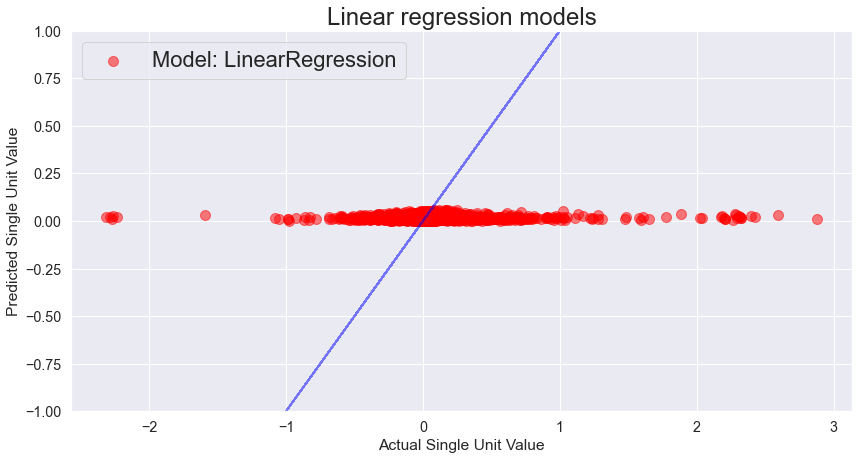

In [77]:
sns.set(font_scale = 1.3)
plt.figure(figsize=(14,7))
plt.plot(y_validate.target, y_validate.target, alpha=.5, color="blue", label='_nolegend_')
plt.scatter(y_validate.target, y_validate.logerror_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.ylim(-1,1)
sns.set(font_scale = 2)
plt.legend()
plt.xlabel("Actual Single Unit Value")
plt.ylabel("Predicted Single Unit Value")
plt.title("Linear regression models")

plt.show()

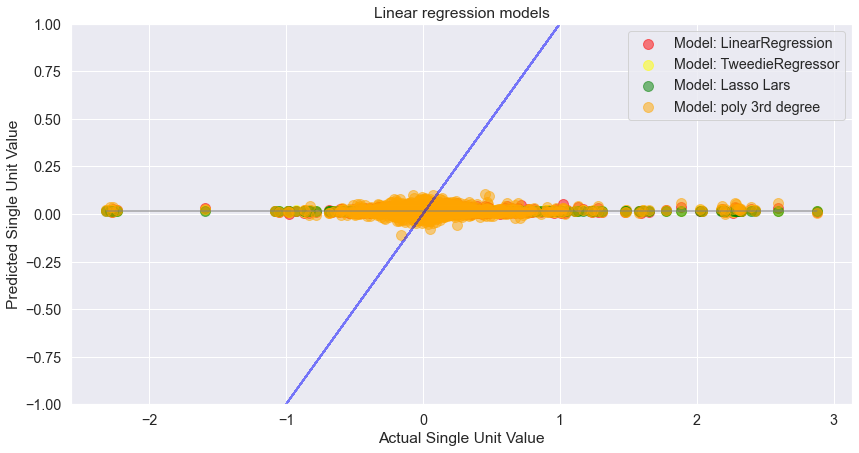

In [78]:
# y_validate.head()
sns.set(font_scale = 1.3)
plt.figure(figsize=(14,7))
# our best baseline model
plt.plot(y_validate.target, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.plot(y_validate.target, y_validate.target, alpha=.5, color="blue", label='_nolegend_')
# plotting the models above
plt.scatter(y_validate.target, y_validate.logerror_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.target, y_validate.logerror_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.target, y_validate.logerror_pred_lars, 
            alpha=.5, color="green", s=100, label="Model: Lasso Lars")
plt.scatter(y_validate.target, y_validate.logerror_pred_lm3, 
            alpha=.5, color="orange", s=100, label="Model: poly 3rd degree")
plt.ylim(-1,1)
plt.legend()
plt.xlabel("Actual Single Unit Value")
plt.ylabel("Predicted Single Unit Value")
plt.title("Linear regression models")

plt.show()

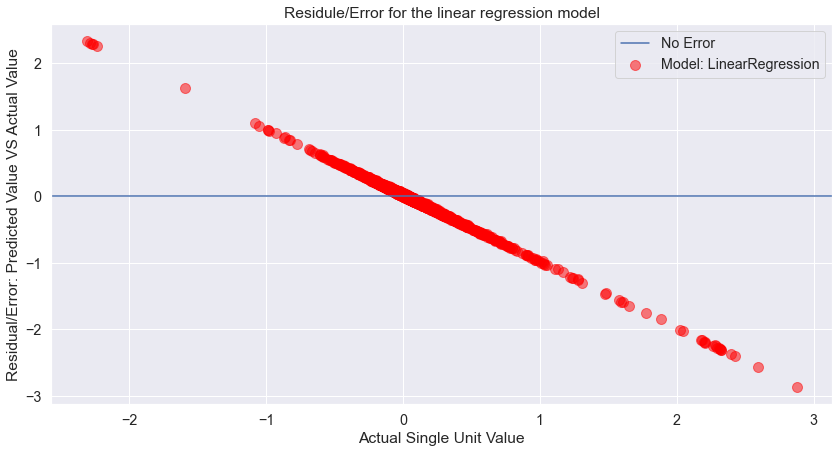

In [79]:
# Lets look at the residuals for our best model (Linear regression)
sns.set(font_scale = 1.3)
plt.figure(figsize=(14,7))
plt.axhline(label="No Error")
plt.scatter(y_validate.target, y_validate.logerror_pred_lm - y_validate.target, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Single Unit Value")
plt.ylabel("Residual/Error: Predicted Value VS Actual Value")
plt.title("Residule/Error for the linear regression model")

plt.show()

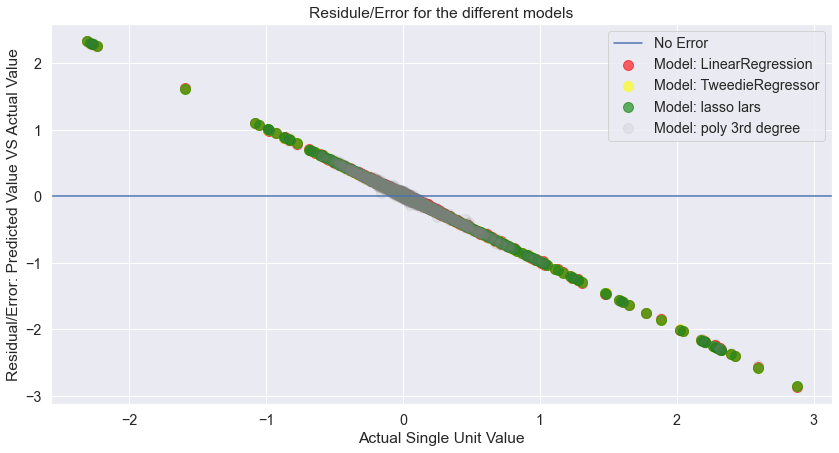

In [80]:
# now lets look at the residuals for all the models
sns.set(font_scale = 1.3)
plt.figure(figsize=(14,7))
plt.axhline(label="No Error")
plt.scatter(y_validate.target, y_validate.logerror_pred_lm - y_validate.target , 
            alpha=.6, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.target, y_validate.logerror_pred_glm - y_validate.target, 
            alpha=.6, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.target, y_validate.logerror_pred_lars - y_validate.target, 
            alpha=.6, color="green", s=100, label="Model: lasso lars")
plt.scatter(y_validate.target, y_validate.logerror_pred_lm3 - y_validate.target, 
            alpha=.1, color="grey", s=100, label="Model: poly 3rd degree")
plt.legend()
plt.xlabel("Actual Single Unit Value")
plt.ylabel("Residual/Error: Predicted Value VS Actual Value")
plt.title("Residule/Error for the different models")
plt.show()

In [81]:
# We are going to move forward with testing on the linear regression model

In [82]:
# Getting baseline to compare with my lm model
y_test['logerror_pred_mean'] = logerror_pred_mean
# Getting RMSE for baseline
rmse_test_mean = mean_squared_error(y_test.target, y_test.logerror_pred_mean) ** (1/2)

In [83]:
r2_score_mean = r2_score(y_test.target, y_test.logerror_pred_mean)

In [84]:
# predict on test
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.target, y_test.logerror_pred_lm) ** (1/2)

In [85]:
r2_score_model = r2_score(y_test.target, y_test.logerror_pred_lm)

In [86]:
print("Linear Regression models performance on test")
print(f"RMSE: {rmse_test}")
print(f"R^2: {r2_score_model}")
print("____________________________________________")
print("Baseline models performance on test")
print(f"RMSE: {rmse_test_mean}")
print(f"R^2: {r2_score_mean}")

Linear Regression models performance on test
RMSE: 0.16564257105761176
R^2: 0.00038739137552989966
____________________________________________
Baseline models performance on test
RMSE: 0.16567579173367558
R^2: -1.3606223907114412e-05


## Conclusion
- We were able to find some indicators of of log error but will definetly need more time to create a better model.
- the model beat the baseline by a slim margin
- Both my model and the baseline had an **RMSE of ~.1656**

## Next Steps
- I could spend 1000 hours and still continue learning new things about this data.
- I would try to make clusters that target on a neighborhood level, seeking values that the homes on the same street sold for.
- I would also improve on my models using my current model as the new baseline.